# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

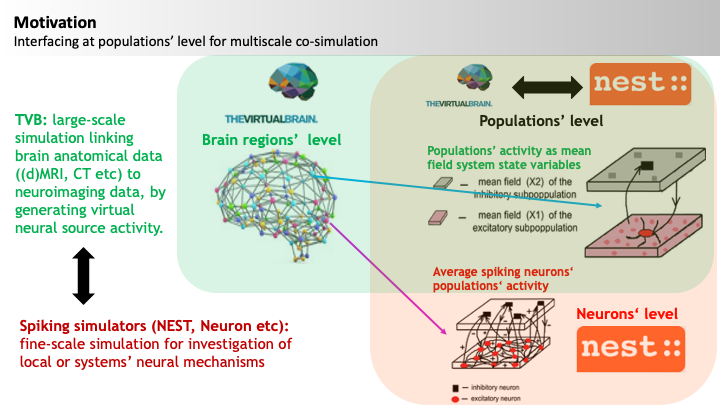

In [1]:
from IPython.core.display import Image, display
display(Image(filename='./pics/ConceptGraph1.png',  width=1000, unconfined=False))

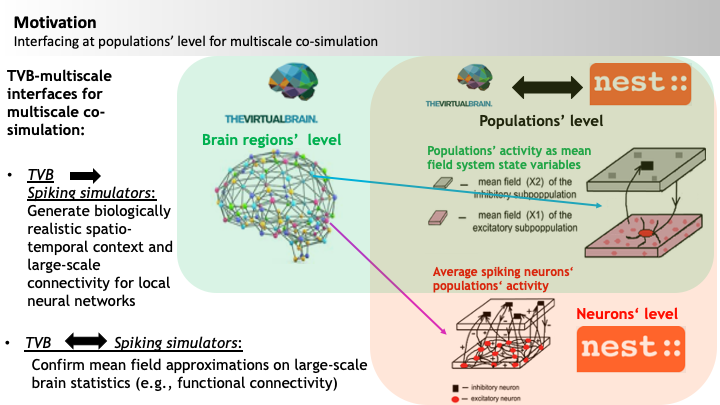

In [2]:
display(Image(filename='./pics/ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

# TVB - NEST co-simulation 

## Linear TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

(Post)Synaptic gating dynamics (i.e., proportion of synapse channels open at any given time):

$\tau\dot{R_{n\prime}} = - {R_{n\prime}}(t) + G\sum_{{m}\neq {n\prime}}C_{{m}{n\prime}}R_{m}(t-\tau_{{m}{n\prime}})(t) + I_o(t) $

for $n\prime$ regions modelled in TVB ($m$ all nodes), 

and

$\tau_{Rin}\dot{R_{n}} = - {R_{n}}(t) + {Rin_{n}}(t) $

for $n$ region modelled in NEST, and updating TVB via the ${Rin_{n}}(t)$ instant rate.

 ${Rin_{n\prime}}(t) = 0.0$ for all $n\prime$ TVB nodes.

### Parameters:

- structural TVB connectivity weights $C_{{m\prime}{n\prime}}$ (${m\prime}->{n\prime}$)
- structural TVB connectivity delays $\tau_{{m\prime}{n\prime}}$  (${m\prime}->{n\prime}$)
- global structural brain connectivity coupling constant $G$
- overall effective external input current $I_o = 0.0 except for stimulua application where I_o = 100$ 
- time constant $\tau = 10 ms$ 
- time constant of linear integration of NEST instant rate update $\tau_{Rin} = 10 ms$ 


## Cerebellum Spiking network model in NEST

To be filled in!...

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ interface_{weight} * R(t) $, 

Spike generator NEST devices are used as TVB "proxy" nodes and generate spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $



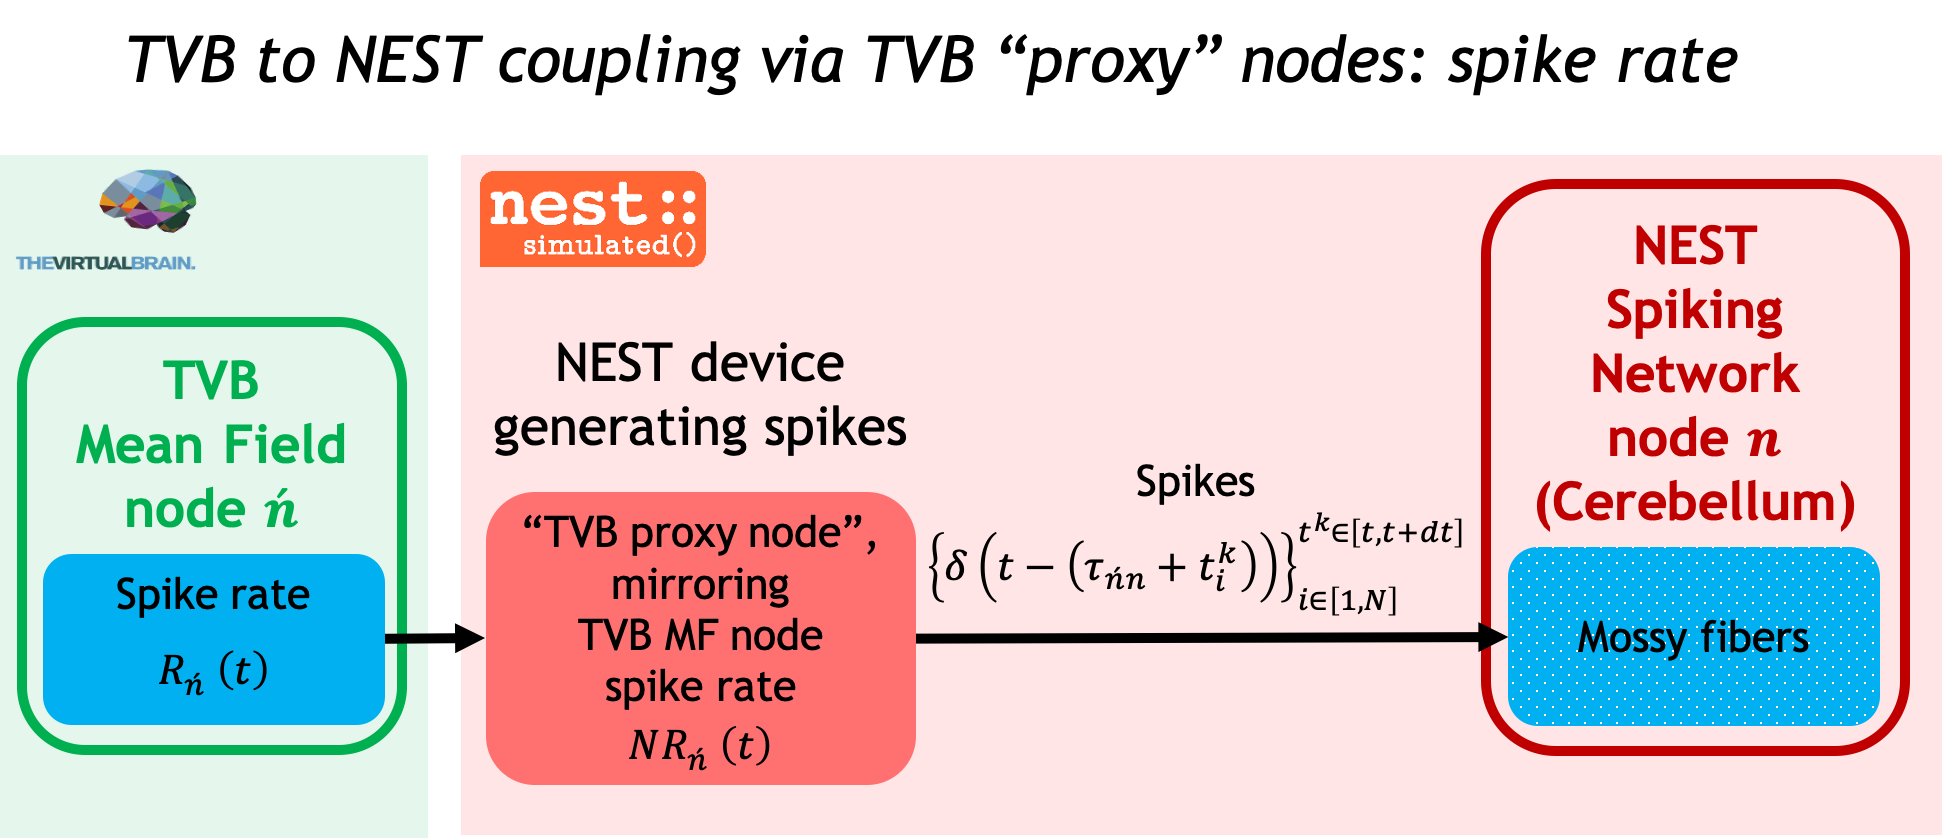

In [3]:
display(Image(filename='./pics/Rate_cereb_linear.png',  width=1000, unconfined=False))

## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides an auxiliary TVB state variables $R_{in}(t)$:

$ {R_{in_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in R_n}}{nNeurons * dt} $ in  spikes/sec.

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


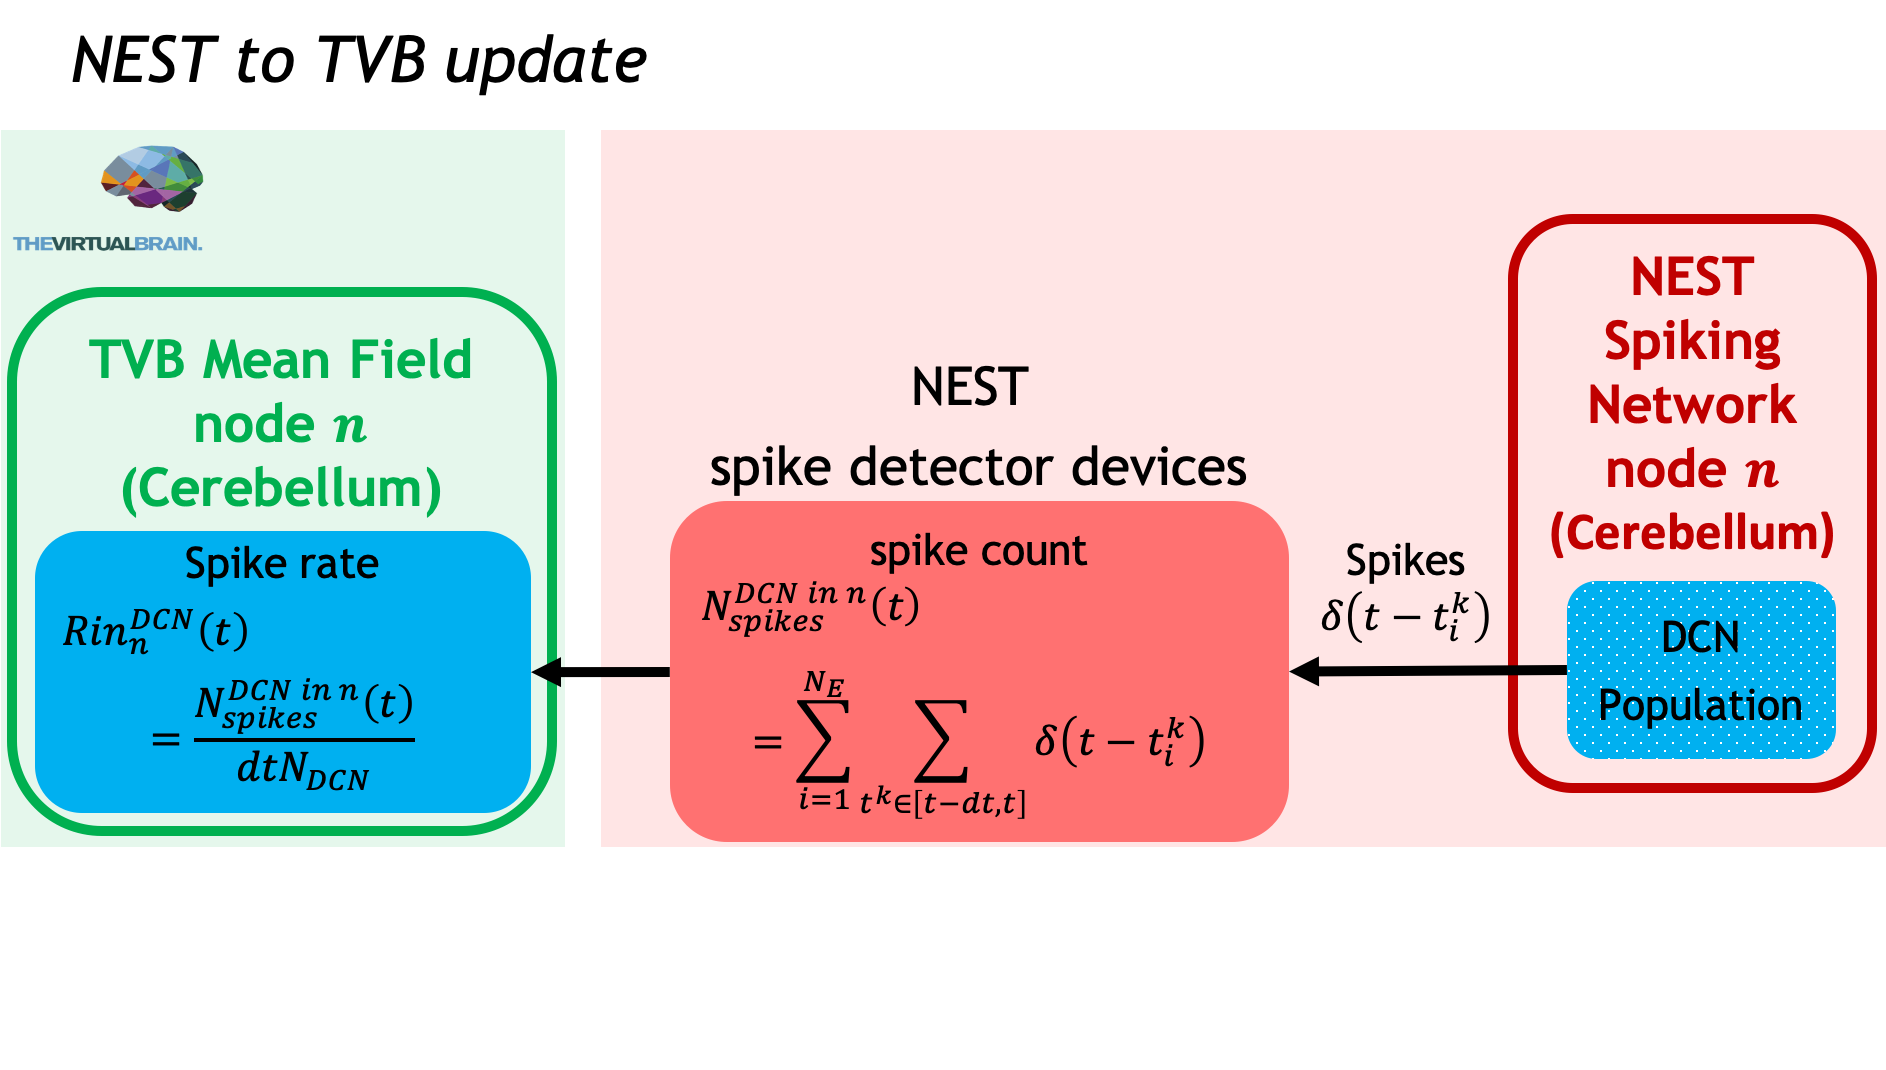

In [4]:
display(Image(filename='./pics/NESTtoTVB_cereb_linear.png',  width=1000, unconfined=False))

## Simulator loop

### Simulating several (i.e., 4) NEST time steps for every 1 TVB time step for stable integration

# WORKFLOW:

In [5]:
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *
home_path = "/home/docker/packages/tvb-multiscale"
notebooks_path = os.path.join(home_path, "docs/documented_example_notebook")
config = Config(output_base=os.path.join(notebooks_path, "outputs_Cereb"))
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

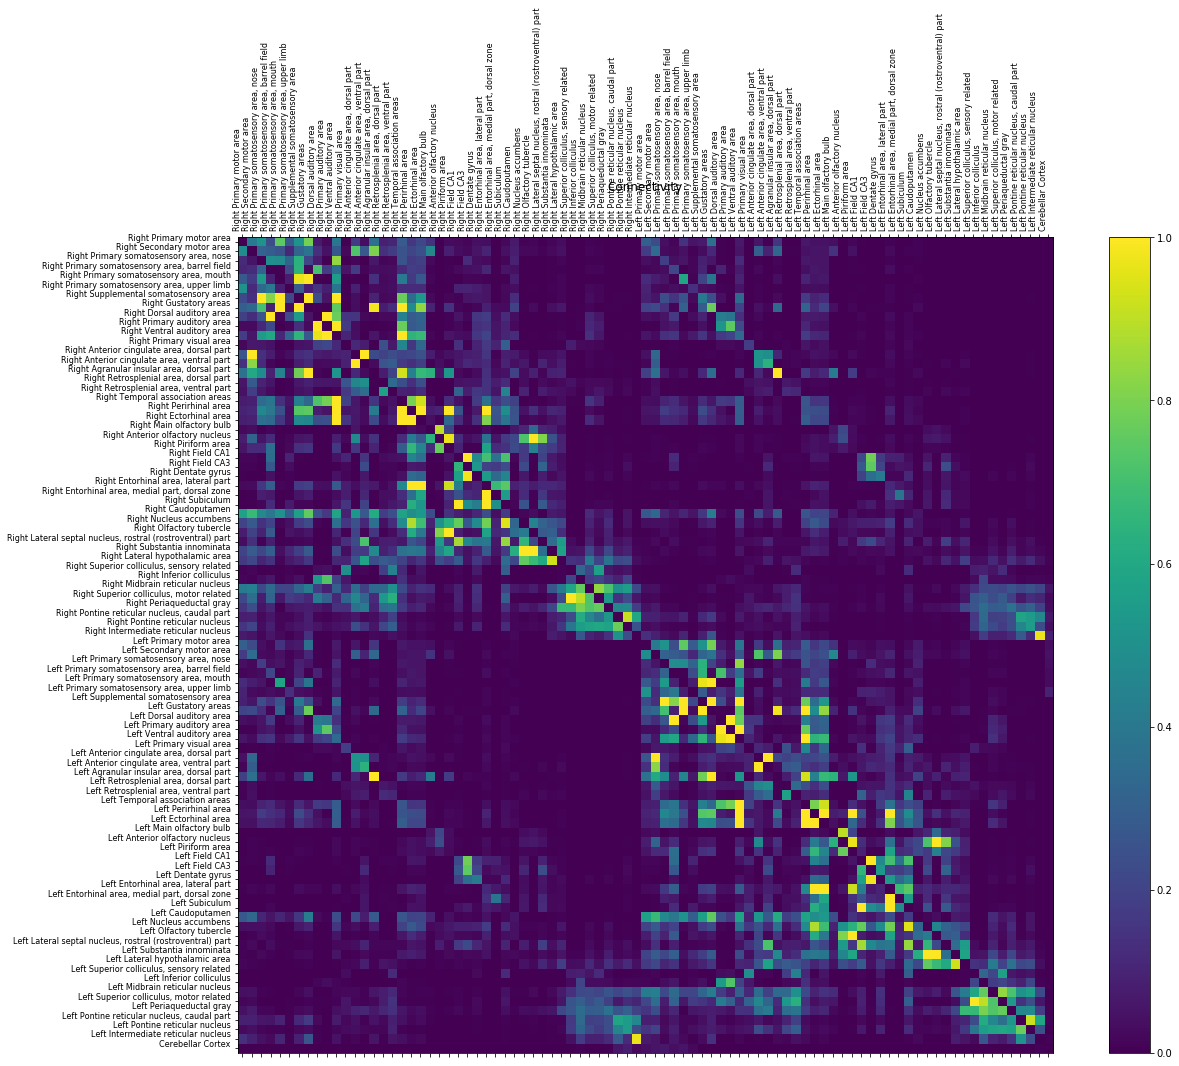

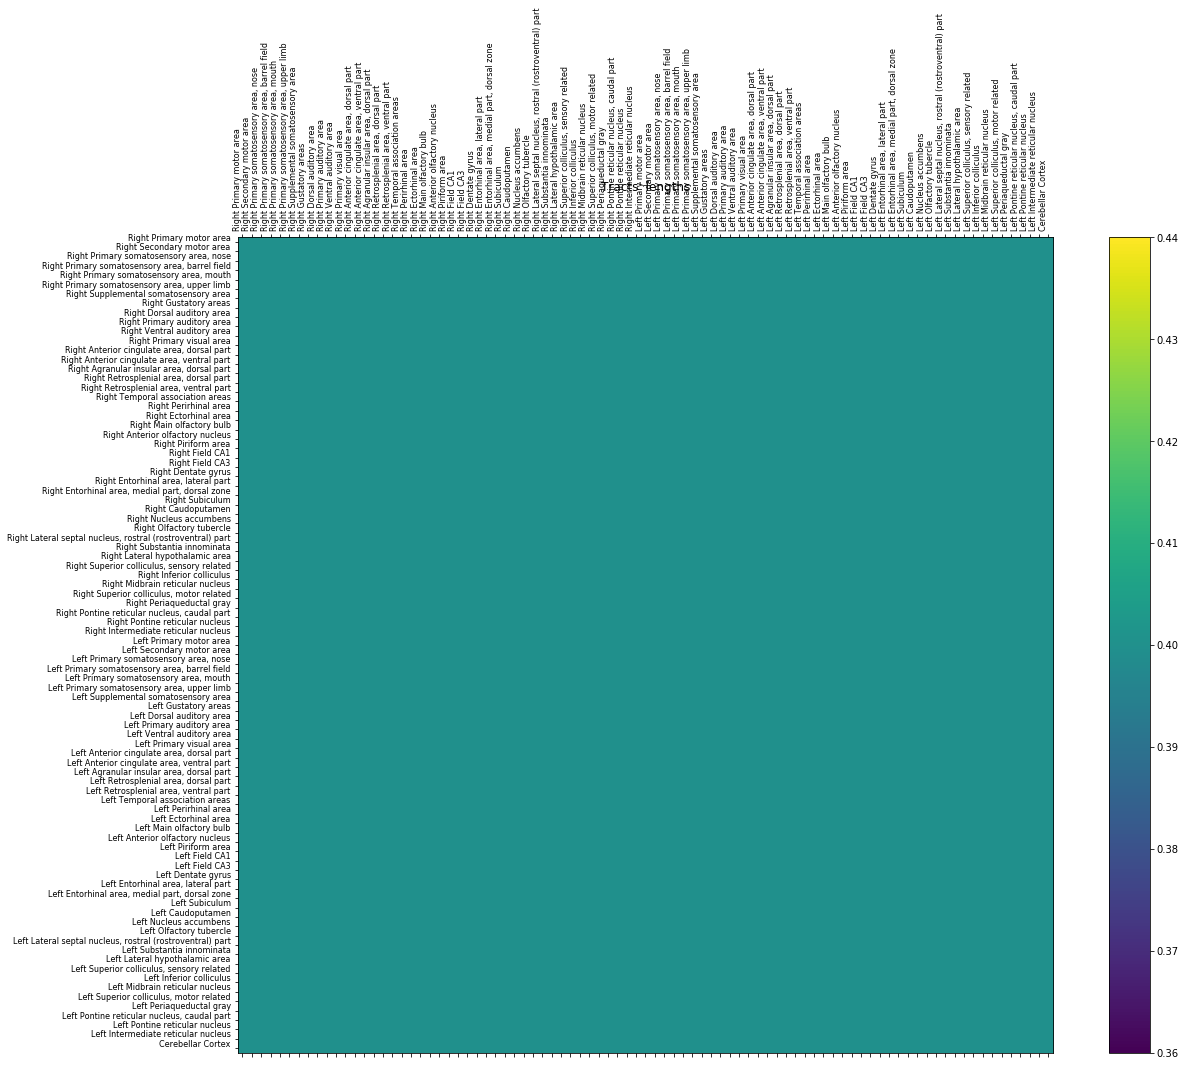

In [6]:
from tvb.simulator.models.linear_with_stimulus import Linear
from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG


# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
model_params = {"I_o": np.array([0.0]), "G": np.array([16.0]), "tau": np.array([10.0]), "tau_rin": np.array([10.0])}
simulator.model = Linear(**model_params)

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([0.001])


# Load connectivity
# config.DEFAULT_CONNECTIVITY_ZIP = "/home/docker/packages/tvb_data/tvb_data/mouse/allen_2mm/ConnectivityAllen2mm.zip"                                  
# connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)
import os
DATA_PATH = os.path.join(home_path, "examples/tvb_nest/data")
w = np.loadtxt(os.path.join(DATA_PATH, "mouse_cereb_sum_weights.txt"))
# t = np.loadtxt(os.path.join(DATA_PATH, "tract_lengths_Count_plusCRBL.txt"))
# forcing one time step delay for all connections:
speed = 4.0
t = speed * simulator.integrator.dt * np.ones(w.shape)  
# brain_regions_path = os.path.join(DATA_PATH, "centres_brain_MNI.txt")
# rl = np.loadtxt(brain_regions_path,dtype="str", usecols=(0,))
with open(os.path.join(DATA_PATH, "mouse_cereb_regions_labels.txt"), "r") as text: 
    rl = [] 
    for line in text: 
        rl.append(line)
rl = np.array(rl)
# c = np.loadtxt(brain_regions_path, usecols=range(1,3))
c = np.random.uniform((w.shape[0], 3))
connectivity=Connectivity(region_labels=rl, weights=w, centres=c, tract_lengths=t)

# Normalize connectivity weights
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
connectivity.weights[connectivity.weights > 1.0] = 1.0

connectivity.speed = np.array([speed])
connectivity.configure()

#white_matter_coupling = coupling.Linear(a=0.014)
simulator.connectivity = connectivity

simulator.model.I_o = simulator.model.I_o[0] * np.ones((simulator.connectivity.number_of_regions, ))

simulator.initial_conditions = np.zeros((2, 2, simulator.connectivity.number_of_regions, 1))

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

plotter.plot_tvb_connectivity(simulator.connectivity);

## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [7]:
# Select the regions for the fine scale modeling with NEST spiking networks
nest_nodes_ids = []
for i_region, reg_lbl in enumerate(simulator.connectivity.region_labels):
    if "cereb" in reg_lbl.lower():
        nest_nodes_ids.append(i_region)  # the indices of fine scale regions modeled with NEST
if len(nest_nodes_ids) == 0:
    nest_nodes_ids = [simulator.connectivity.number_of_regions-1]

print(["%d. %s" % (nest_node_id, simulator.connectivity.region_labels[nest_node_id]) for nest_node_id in nest_nodes_ids])


['86. Cerebellar Cortex\n']


In [8]:
connections_to_cereb = simulator.connectivity.weights[:, nest_nodes_ids[0]]
sorted_connections_to_cereb = np.argsort(connections_to_cereb)[::-1]
print("sorted_connections_to_cereb =\n") 
for conn_id in sorted_connections_to_cereb:
    print("\n%d. %s, w = %g" % 
          (conn_id, simulator.connectivity.region_labels[conn_id], connections_to_cereb[conn_id]))
connections_from_cereb = simulator.connectivity.weights[nest_nodes_ids[0], :]
sorted_connections_from_cereb = np.argsort(connections_from_cereb)[::-1]
print("sorted_connections_from_cereb =\n") 
for conn_id in sorted_connections_from_cereb:
    print("\n%d. %s, w = %g" % 
          (conn_id, simulator.connectivity.region_labels[conn_id], connections_from_cereb[conn_id]))

sorted_connections_to_cereb =


48. Left Primary somatosensory area, upper limb
, w = 0.0932998

42. Right Intermediate reticular nucleus
, w = 0.0880885

40. Right Pontine reticular nucleus, caudal part
, w = 0.0636727

37. Right Midbrain reticular nucleus
, w = 0.0546067

44. Left Secondary motor area
, w = 0.0496462

41. Right Pontine reticular nucleus
, w = 0.0425532

45. Left Primary somatosensory area, nose
, w = 0.0414891

43. Left Primary motor area
, w = 0.0386569

39. Right Periaqueductal gray
, w = 0.031503

47. Left Primary somatosensory area, mouth
, w = 0.029014

46. Left Primary somatosensory area, barrel field
, w = 0.0285768

38. Right Superior colliculus, motor related
, w = 0.0242839

36. Right Inferior colliculus
, w = 0.0100387

85. Left Intermediate reticular nucleus
, w = 0.0100387

34. Right Lateral hypothalamic area
, w = 0.00874441

83. Left Pontine reticular nucleus, caudal part
, w = 0.00874441

33. Right Substantia innominata
, w = 0.00532426

82. Left Peri

In [9]:
stim_node_id = 42
print("TVB stimulus to %d. Right Intermediate reticular nucleus, w = %g" % 
      (stim_node_id, connections_to_cereb[stim_node_id]))
connections_from_stim = simulator.connectivity.weights[stim_node_id, :]
sorted_connections_from_stim = np.argsort(connections_from_stim)[::-1]
print("which connects to...")
print("sorted_connections_from 42. Right Intermediate reticular nucleus =\n") 
for conn_id in sorted_connections_from_stim:
    print("\n%d. %s, w = %g" % 
          (conn_id, simulator.connectivity.region_labels[conn_id], connections_from_stim[conn_id]))


TVB stimulus to 42. Right Intermediate reticular nucleus, w = 0.0880885
which connects to...
sorted_connections_from 42. Right Intermediate reticular nucleus =


85. Left Intermediate reticular nucleus
, w = 0.968941

40. Right Pontine reticular nucleus, caudal part
, w = 0.508016

83. Left Pontine reticular nucleus, caudal part
, w = 0.280905

36. Right Inferior colliculus
, w = 0.267882

50. Left Gustatory areas
, w = 0.266632

41. Right Pontine reticular nucleus
, w = 0.235505

79. Left Inferior colliculus
, w = 0.178339

7. Right Gustatory areas
, w = 0.143117

39. Right Periaqueductal gray
, w = 0.141712

43. Left Primary motor area
, w = 0.133181

82. Left Periaqueductal gray
, w = 0.124646

84. Left Pontine reticular nucleus
, w = 0.118945

47. Left Primary somatosensory area, mouth
, w = 0.102337

37. Right Midbrain reticular nucleus
, w = 0.0986773

81. Left Superior colliculus, motor related
, w = 0.0892957

44. Left Secondary motor area
, w = 0.0888689

80. Left Midbrain ret

In [10]:
# Build a NEST network model with the corresponding builder
from tvb_multiscale.tvb_nest.nest_models.builders.models.cereb import CerebBuilder

# Using all default parameters for this example
nest_model_builder = CerebBuilder(simulator, nest_nodes_ids, 
                                  os.path.join(DATA_PATH, "cerebellar_cortex_scaffold_dcn.hdf5"),
                                  config=config)
nest_model_builder.modules_to_install = ["cereb"]

# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default  builder configuration------------------------
# # ----------------------------------------------------------------------------------------------------------------
# import h5py

# # Synapse parameters: in E-GLIF, 3 synaptic receptors are present:
# # the first is always associated to exc,
# # the second to inh,
# # the third to remaining synapse type
# Erev_exc = 0.0  # [mV]	# [Cavallari et al, 2014]
# Erev_inh = -80.0  # [mV]
# # tau_exc for pc is for pf input; tau_exc for goc is for mf input; tau_exc for mli is for pf input:
# tau_exc = {'golgi': 0.23, 'granule': 5.8, 'purkinje': 1.1, 'basket': 0.64, 'stellate': 0.64, 'dcn': 1.0,
#            'dcnp': 3.64,
#            'io': 1.0}
# tau_inh = {'golgi': 10.0, 'granule': 13.61, 'purkinje': 2.8, 'basket': 2.0, 'stellate': 2.0, 'dcn': 0.7,
#            'dcnp': 1.14, 'io': 60.0}
# tau_exc_cfpc = 0.4
# tau_exc_pfgoc = 0.5
# tau_exc_cfmli = 1.2

# # Single neuron parameters:
# nest_model_builder.neuron_param = {
#         'golgi_cell': {'t_ref': 2.0, 'C_m': 145.0, 'tau_m': 44.0, 'V_th': -55.0, 'V_reset': -75.0, 'Vinit': -62.0,
#                        'E_L': -62.0, 'Vmin': -150.0,
#                        'lambda_0': 1.0, 'tau_V': 0.4, 'I_e': 16.214, 'kadap': 0.217, 'k1': 0.031, 'k2': 0.023,
#                        'A1': 259.988, 'A2': 178.01,
#                        'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['golgi'],
#                        'tau_syn2': tau_inh['golgi'], 'tau_syn3': tau_exc_pfgoc},
#         'granule_cell': {'t_ref': 1.5, 'C_m': 7.0, 'tau_m': 24.15, 'V_th': -41.0, 'V_reset': -70.0, 'Vinit': -62.0,
#                          'E_L': -62.0, 'Vmin': -150.0,
#                          'lambda_0': 1.0, 'tau_V': 0.3, 'I_e': -0.888, 'kadap': 0.022, 'k1': 0.311, 'k2': 0.041,
#                          'A1': 0.01, 'A2': -0.94,
#                          'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['granule'],
#                          'tau_syn2': tau_inh['granule'], 'tau_syn3': tau_exc['granule']},
#         'purkinje_cell': {'t_ref': 0.5, 'C_m': 334.0, 'tau_m': 47.0, 'V_th': -43.0, 'V_reset': -69.0, 'Vinit': -59.0,
#                           'E_L': -59.0,
#                           'lambda_0': 4.0, 'tau_V': 3.5, 'I_e': 742.54, 'kadap': 1.492, 'k1': 0.1950, 'k2': 0.041,
#                           'A1': 157.622, 'A2': 172.622,
#                           'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['purkinje'],
#                           'tau_syn2': tau_inh['purkinje'], 'tau_syn3': tau_exc_cfpc},
#         'basket_cell': {'t_ref': 1.59, 'C_m': 14.6, 'tau_m': 9.125, 'V_th': -53.0, 'V_reset': -78.0, 'Vinit': -68.0,
#                         'E_L': -68.0,
#                         'lambda_0': 1.8, 'tau_V': 1.1, 'I_e': 3.711, 'kadap': 2.025, 'k1': 1.887, 'k2': 1.096,
#                         'A1': 5.953, 'A2': 5.863,
#                         'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['basket'],
#                         'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
#         'stellate_cell': {'t_ref': 1.59, 'C_m': 14.6, 'tau_m': 9.125, 'V_th': -53.0, 'V_reset': -78.0, 'Vinit': -68.0,
#                           'E_L': -68.0,
#                           'lambda_0': 1.8, 'tau_V': 1.1, 'I_e': 3.711, 'kadap': 2.025, 'k1': 1.887, 'k2': 1.096,
#                           'A1': 5.953, 'A2': 5.863,
#                           'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['basket'],
#                           'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
#         'dcn_cell': {'t_ref': 0.8, 'C_m': 142.0,'tau_m': 33.0,'V_th': -36.0,'V_reset': -55.0,'Vinit': -45.0,'E_L': -45.0,
#                          'lambda_0':3.5, 'tau_V':3.0,'I_e': 75.385,'kadap': 0.408,'k1': 0.697, 'k2': 0.047,'A1': 13.857,'A2':3.477,
#                          'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['dcn'], 'tau_syn2': tau_inh['dcn']}}

# # Connection weights
# nest_model_builder.conn_weights = {'mossy_to_glomerulus': 1.0, 'ascending_axon_to_golgi': 0.05, 'ascending_axon_to_purkinje': 0.175,
#                     'basket_to_purkinje': 3.638,
#                     'glomerulus_to_golgi': 0.0125, 'glomerulus_to_granule': 0.361, 'golgi_to_granule': 0.338,
#                     'parallel_fiber_to_basket': 0.002, 'parallel_fiber_to_golgi': 0.008,
#                     'parallel_fiber_to_purkinje': 0.044,
#                     'parallel_fiber_to_stellate': 0.003, 'stellate_to_purkinje': 1.213, 
#                     'mossy_to_dcn': 0.5, 'purkinje_to_dcn': 0.45}

# # Connection delays
# nest_model_builder.conn_delays = \
#     {'mossy_to_glomerulus': 1.0, 'ascending_axon_to_golgi': 2.0, 'ascending_axon_to_purkinje': 2.0,
#      'basket_to_purkinje': 4.0, 'glomerulus_to_golgi': 4.0, 'glomerulus_to_granule': 4.0, 'golgi_to_granule': 2.0,
#      'parallel_fiber_to_basket': 5.0, 'parallel_fiber_to_golgi': 5.0, 'parallel_fiber_to_purkinje': 5.0,
#      'parallel_fiber_to_stellate': 5.0, 'stellate_to_purkinje': 5.0, 
#      'mossy_to_dcn': 4.0, 'purkinje_to_dcn': 4.0}

# # Connection receptors
# nest_model_builder.conn_receptors = \
#     {'ascending_axon_to_golgi': 3, 'ascending_axon_to_purkinje': 1, 'basket_to_purkinje': 2,
#      'glomerulus_to_golgi': 1, 'glomerulus_to_granule': 1, 'golgi_to_granule': 2,
#      'parallel_fiber_to_basket': 1, 'parallel_fiber_to_golgi': 3, 'parallel_fiber_to_purkinje': 1,
#      'parallel_fiber_to_stellate': 1, 'stellate_to_purkinje': 2, 
#      'mossy_to_dcn': 1, 'purkinje_to_dcn': 2}

# # Connection pre and post-synaptic neurons
# nest_model_builder.conn_pre_post = \
#     {'mossy_to_glomerulus': {'pre': 'mossy_fibers', 'post': 'glomerulus'},
#      'ascending_axon_to_golgi': {'pre': 'granule_cell', 'post': 'golgi_cell'},
#      'ascending_axon_to_purkinje': {'pre': 'granule_cell', 'post': 'purkinje_cell'},
#      'basket_to_purkinje': {'pre': 'basket_cell', 'post': 'purkinje_cell'},
#      'glomerulus_to_golgi': {'pre': 'glomerulus', 'post': 'golgi_cell'},
#      'glomerulus_to_granule': {'pre': 'glomerulus', 'post': 'granule_cell'},
#      'golgi_to_granule': {'pre': 'golgi_cell', 'post': 'granule_cell'},
#      'parallel_fiber_to_basket': {'pre': 'granule_cell', 'post': 'basket_cell'},
#      'parallel_fiber_to_golgi': {'pre': 'granule_cell', 'post': 'golgi_cell'},
#      'parallel_fiber_to_purkinje': {'pre': 'granule_cell', 'post': 'purkinje_cell'},
#      'parallel_fiber_to_stellate': {'pre': 'granule_cell', 'post': 'stellate_cell'},
#      'stellate_to_purkinje': {'pre': 'stellate_cell', 'post': 'purkinje_cell'}, 
#      'purkinje_to_dcn': {'pre': 'purkinje_cell', 'post': 'dcn_cell'}}

# nest_model_builder.RECORD_VM = True
# nest_model_builder.TOT_DURATION = 350.  # 350 mseconds
# nest_model_builder.STIM_START = 150.  # 150 beginning of stimulation
# nest_model_builder.STIM_END = 250.  # 250 end of stimulation
# nest_model_builder.STIM_FREQ = 100.  # Frequency in Hz
# nest_model_builder.BACKGROUND_FREQ = 4.

# # Load the network source file:
# nest_model_builder.net_src_file = h5py.File(nest_model_builder.path_to_network_source_file, 'r+')

# # Populations' configurations
# nest_model_builder.neuron_types = list(nest_model_builder.net_src_file['cells/placement'].keys())
# ordered_neuron_types = []
# nest_model_builder.ordered_neuron_types = ['mossy_fibers', 'glomerulus', "granule_cell", "golgi_cell",
#                                            "basket_cell", "stellate_cell", "purkinje_cell", "dcn_cell"]
# for neuron_type in nest_model_builder.ordered_neuron_types:
#     ordered_neuron_types.append(
#         nest_model_builder.neuron_types.pop(
#             nest_model_builder.neuron_types.index(neuron_type)))
# ordered_neuron_types += nest_model_builder.neuron_types
# nest_model_builder.neuron_types = ordered_neuron_types

# nest_model_builder.populations = []
# nest_model_builder.start_id_scaffold = {}
# # All cells are modelled as E-GLIF models;
# # with the only exception of Glomeruli and Mossy Fibers (not cells, just modeled as
# # relays; i.e., parrot neurons)
# for neuron_name in nest_model_builder.neuron_types:
#     if neuron_name != 'glomerulus' and neuron_name != 'mossy_fibers':
#         model = 'eglif_cond_alpha_multisyn'
#     else:
#         model = 'parrot_neuron'
#     n_neurons = np.array(nest_model_builder.net_src_file['cells/placement/' + neuron_name + '/identifiers'])[1]
#     nest_model_builder.populations.append(
#                 {"label": neuron_name, "model": model,
#                  "params": nest_model_builder.neuron_param.get(neuron_name, {}),
#                  "scale": n_neurons,
#                  "nodes": None})
#     nest_model_builder.start_id_scaffold[neuron_name] = \
#                 np.array(nest_model_builder.net_src_file['cells/placement/' + neuron_name + '/identifiers'])[0]

# class NeuronsIndsFun(object):
#     conns = np.array([])
#     start_id_scaffold = 0

#     def __init__(self, start_id_scaffold, conns):
#         self.start_id_scaffold = start_id_scaffold
#         self.conns = conns

#     def __call__(self, neurons_inds):
#         return [int(x - self.start_id_scaffold + neurons_inds[0])
#                 for x in self.conns]
    
# # Within brain regions' nodes connections among populations:
# nest_model_builder.default_populations_connection["conn_spec"]["rule"] = "one_to_one"
# nest_model_builder.populations_connections = []
# for conn_name in nest_model_builder.conn_weights.keys():
#     conn = np.array(nest_model_builder.net_src_file['cells/connections/'+conn_name])
#     pre_name = nest_model_builder.conn_pre_post[conn_name]["pre"]
#     post_name = nest_model_builder.conn_pre_post[conn_name]["post"]
#     nest_model_builder.populations_connections.append(
#         {"source": pre_name, "target": post_name,
#          "source_inds": NeuronsIndsFun(nest_model_builder.start_id_scaffold[pre_name], conn[:, 0].flatten()),
#          "target_inds": NeuronsIndsFun(nest_model_builder.start_id_scaffold[post_name], conn[:, 1].flatten()),
#          "model": 'static_synapse',
#          "conn_spec": nest_model_builder.default_populations_connection["conn_spec"],
#          "weight": nest_model_builder.conn_weights[conn_name],
#          "delay": nest_model_builder.conn_delays[conn_name],
#          "receptor_type": nest_model_builder.conn_receptors.get(conn_name, 0),
#          "nodes": None
#         }
#     )

# # No among brain region regions' nodes' connectivity yet for the NEST Cerebellum network! 
# # Assuming a single Cerebellum region.

# # We don't need the network source file any more. Close it:
# nest_model_builder.net_src_file.close()

# def neurons_inds_fun(neurons_inds, n_neurons=100):
#     # We use this in order to measure up to n_neurons neurons from every population
#     n_neurons_inds = len(neurons_inds)
#     if n_neurons_inds > n_neurons:
#         return tuple(np.array(neurons_inds)[0:-1:int(np.ceil(1.0*n_neurons_inds/n_neurons))])
#     else:
#         return neurons_inds
    
# # Output Devices:
# nest_model_builder.output_devices = []
# # Spike detectors:
# connections = OrderedDict()
# #          label <- target population
# for pop in nest_model_builder.populations:
#     connections[pop["label"] + "_spikes"] = pop["label"]
#     params = dict(nest_model_builder.config.NEST_OUTPUT_DEVICES_PARAMS_DEF["spike_detector"])
#     nest_model_builder.output_devices.append(
#         {"model": "spike_detector", "params": params,
#          "connections": connections, "nodes": None})  # None means all here

# if nest_model_builder.RECORD_VM:    
#     # Multimeters:
#     connections = OrderedDict()
#     #               label    <- target population
#     for pop in nest_model_builder.populations:
#         if pop["label"] != 'glomerulus' and pop["label"] != 'mossy_fibers':
#             connections[pop["label"]] = pop["label"]
#         params = dict(nest_model_builder.config.NEST_OUTPUT_DEVICES_PARAMS_DEF["multimeter"])
#         params["interval"] = nest_model_builder.monitor_period
#         nest_model_builder.output_devices.append(
#                 {"model": "multimeter", "params": params,
#                  "neurons_inds": lambda node, neurons_inds: neurons_inds_fun(neurons_inds),
#                  "connections": connections, "nodes": None})  # None means all here
    
# # Input (stimulus) Devices (needed only when there is no TVB input to the Cerebellum):
# nest_model_builder.input_devices = []
# # # Background spike stimulus :
# # connections = OrderedDict()
# # #             label <- target population
# # connections["Background"] = ['mossy_fibers']
# # nest_model_builder.input_devices.append(
# #     {"model": "poisson_generator",
# #      "params": {"rate": nest_model_builder.BACKGROUND_FREQ, 
# #                 "origin": 0.0, "start": 0.0}, # not necessary: "stop": nest_model_builder.TOT_DURATION
# #      "connections": connections, "nodes": None,
# #      "weights": 1.0, "delays": 0.0, "receptor_type": 0})
# # # Spike stimulus 
# # connections = OrderedDict()
# # #             label <- target population
# # connections["Stimulus"] = ['mossy_fibers']
# # nest_model_builder.input_devices.append(
# #     {"model": "poisson_generator",
# #      "params": {"rate": nest_model_builder.STIM_FREQ, "origin": 0.0, 
# #                 "start": nest_model_builder.STIM_START, "stop": nest_model_builder.STIM_END},
# #      "connections": connections, "nodes": None,
# #      "weights": 1.0, "delays": 0.0, "receptor_type": 0})

# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------


# nest_network = nest_model_builder.build_spiking_network()


# or build the network without using the TVB-NEST NEST network builder...:


# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to build the NEST network without using the NEST model builder of TVB-NEST------------------
# ----------------------------------------------------------------------------------------------------------------
import h5py
!rm *.gdf
!rm *.dat

nest_model_builder.compile_install_nest_modules(["cereb"])

# Synapse parameters: in E-GLIF, 3 synaptic receptors are present: the first is always associated to exc, the second to inh, the third to remaining synapse type
Erev_exc = 0.0		# [mV]	#[Cavallari et al, 2014]
Erev_inh = -80.0		# [mV]
tau_exc = {'golgi': 0.23, 'granule': 5.8, 'purkinje': 1.1, 'basket': 0.64, 'stellate': 0.64, 'dcn': 1.0, 'dcnp': 3.64, 'io': 1.0}		#tau_exc for pc is for pf input; tau_exc for goc is for mf input; tau_exc for mli is for pf input
tau_inh = {'golgi': 10.0, 'granule': 13.61, 'purkinje': 2.8, 'basket': 2.0, 'stellate': 2.0, 'dcn': 0.7, 'dcnp': 1.14, 'io': 60.0}
tau_exc_cfpc = 0.4
tau_exc_pfgoc = 0.5
tau_exc_cfmli = 1.2

# Single neuron parameters:
neuron_param = {'golgi_cell': {'t_ref': 2.0, 'C_m': 145.0,'tau_m': 44.0,'V_th': -55.0,'V_reset': -75.0,'Vinit': -62.0,'E_L': -62.0,'Vmin':-150.0,
                         'lambda_0':1.0, 'tau_V':0.4,'I_e': 16.214,'kadap': 0.217,'k1': 0.031, 'k2': 0.023,'A1': 259.988,'A2':178.01,
                         'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['golgi'], 'tau_syn2': tau_inh['golgi'], 'tau_syn3': tau_exc_pfgoc},
               'granule_cell': {'t_ref': 1.5, 'C_m': 7.0,'tau_m': 24.15,'V_th': -41.0,'V_reset': -70.0,'Vinit': -62.0,'E_L': -62.0,'Vmin': -150.0,
                           'lambda_0':1.0, 'tau_V':0.3,'I_e': -0.888,'kadap': 0.022,'k1': 0.311, 'k2': 0.041,'A1': 0.01,'A2':-0.94,
                           'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['granule'], 'tau_syn2': tau_inh['granule'], 'tau_syn3': tau_exc['granule']},
               'purkinje_cell': {'t_ref': 0.5, 'C_m': 334.0,'tau_m': 47.0,'V_th': -43.0,'V_reset': -69.0,'Vinit': -59.0,'E_L': -59.0,
                            'lambda_0':4.0, 'tau_V':3.5,'I_e': 742.54,'kadap': 1.492,'k1': 0.1950, 'k2': 0.041,'A1': 157.622,'A2':172.622,
                            'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['purkinje'], 'tau_syn2': tau_inh['purkinje'], 'tau_syn3': tau_exc_cfpc},
               'basket_cell': {'t_ref': 1.59, 'C_m': 14.6,'tau_m': 9.125,'V_th': -53.0,'V_reset': -78.0,'Vinit': -68.0,'E_L': -68.0,
                          'lambda_0':1.8, 'tau_V':1.1,'I_e': 3.711,'kadap': 2.025,'k1': 1.887, 'k2': 1.096,'A1': 5.953,'A2':5.863,
                          'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['basket'], 'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
               'stellate_cell': {'t_ref': 1.59, 'C_m': 14.6,'tau_m': 9.125,'V_th': -53.0,'V_reset': -78.0,'Vinit': -68.0,'E_L': -68.0,
                            'lambda_0':1.8, 'tau_V':1.1,'I_e': 3.711,'kadap': 2.025,'k1': 1.887, 'k2': 1.096,'A1': 5.953,'A2':5.863,
                            'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['basket'], 'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
               'dcn_cell': {'t_ref': 0.8, 'C_m': 142.0,'tau_m': 33.0,'V_th': -36.0,'V_reset': -55.0,'Vinit': -45.0,'E_L': -45.0,
                         'lambda_0':3.5, 'tau_V':3.0,'I_e': 75.385,'kadap': 0.408,'k1': 0.697, 'k2': 0.047,'A1': 13.857,'A2':3.477,
                         'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['dcn'], 'tau_syn2': tau_inh['dcn']}}


# Connection weights
conn_weights = {'mossy_to_glomerulus': 1.0,'ascending_axon_to_golgi': 0.05, 'ascending_axon_to_purkinje': 0.175, 'basket_to_purkinje': 3.638,\
                'glomerulus_to_golgi': 0.0125, 'glomerulus_to_granule': 0.361, 'golgi_to_granule': 0.338,\
                'parallel_fiber_to_basket': 0.002, 'parallel_fiber_to_golgi': 0.008,'parallel_fiber_to_purkinje': 0.044,\
                'parallel_fiber_to_stellate': 0.003, 'stellate_to_purkinje': 1.213,\
                'mossy_to_dcn': 0.5, 'purkinje_to_dcn': 0.45}


# Connection delays
conn_delays = {'mossy_to_glomerulus': 1.0,'ascending_axon_to_golgi': 2.0, 'ascending_axon_to_purkinje': 2.0, 'basket_to_purkinje': 4.0,
               'glomerulus_to_golgi': 4.0, 'glomerulus_to_granule': 4.0, 'golgi_to_granule': 2.0,
               'parallel_fiber_to_basket': 5.0, 'parallel_fiber_to_golgi': 5.0,'parallel_fiber_to_purkinje': 5.0,
               'parallel_fiber_to_stellate': 5.0, 'stellate_to_purkinje':5.0,\
               'mossy_to_dcn': 4.0, 'purkinje_to_dcn': 4.0}

# Connection receptors
conn_receptors = {'ascending_axon_to_golgi': 3, 'ascending_axon_to_purkinje': 1, 'basket_to_purkinje': 2,
               'glomerulus_to_golgi': 1, 'glomerulus_to_granule': 1, 'golgi_to_granule': 2,
               'parallel_fiber_to_basket': 1, 'parallel_fiber_to_golgi': 3,'parallel_fiber_to_purkinje': 1,
               'parallel_fiber_to_stellate': 1, 'stellate_to_purkinje': 2, \
               'mossy_to_dcn': 1, 'purkinje_to_dcn': 2}


# Connection pre and post-synaptic neurons
conn_pre_post = {'mossy_to_glomerulus': {'pre': 'mossy_fibers', 'post': 'glomerulus'},\
                 'ascending_axon_to_golgi': {'pre': 'granule_cell', 'post': 'golgi_cell'},\
                 'ascending_axon_to_purkinje': {'pre': 'granule_cell', 'post': 'purkinje_cell'},\
                 'basket_to_purkinje': {'pre': 'basket_cell', 'post': 'purkinje_cell'},\
                 'glomerulus_to_golgi': {'pre': 'glomerulus', 'post': 'golgi_cell'}, \
                 'glomerulus_to_granule': {'pre': 'glomerulus', 'post': 'granule_cell'}, \
                 'golgi_to_granule': {'pre': 'golgi_cell', 'post': 'granule_cell'},\
                 'parallel_fiber_to_basket': {'pre': 'granule_cell', 'post': 'basket_cell'}, \
                 'parallel_fiber_to_golgi': {'pre': 'granule_cell', 'post': 'golgi_cell'},\
                 'parallel_fiber_to_purkinje': {'pre': 'granule_cell', 'post': 'purkinje_cell'},\
                 'parallel_fiber_to_stellate': {'pre': 'granule_cell', 'post': 'stellate_cell'}, \
                 'stellate_to_purkinje': {'pre': 'stellate_cell', 'post': 'purkinje_cell'},\
                 'mossy_to_dcn': {'pre': 'mossy_fibers', 'post': 'dcn_cell'},\
                 'purkinje_to_dcn': {'pre': 'purkinje_cell', 'post': 'dcn_cell'}}


# Get the nest instance of the NEST model builder:
nest = nest_model_builder.nest_instance
nest_model_builder._configure_nest_kernel()

# Prepare the NEST kernel:
# nest.ResetKernel()
# nest.set_verbosity('M_ERROR')
# nest.SetKernelStatus({"local_num_threads" : cpu_count()})

# Load the network source file:
f = h5py.File(nest_model_builder.path_to_network_source_file, 'r+')

neuron_types = list(f['cells/placement'].keys())
ordered_neuron_types = []
for neuron_type in ['mossy_fibers', 'glomerulus', "granule_cell", "golgi_cell", 
                    "basket_cell", "stellate_cell", "purkinje_cell"]:
    ordered_neuron_types.append(neuron_types.pop(neuron_types.index(neuron_type)))
ordered_neuron_types += neuron_types
neuron_types = ordered_neuron_types
print(neuron_types)

neuron_number = {}
start_id_scaffold = {}

# ### Creating population of neurons
# Instantiate conductance based Extended-Generalized Leaky Integrate and Fire models (E-GLIF) for each cell type. 
# The only exception is represented by Glomeruli and Mossy Fibers; these are not actual cells but just 'relays', 
# used to deliver input spikes to other cells. Here, Glomeruli are created as *parrot_neurons*

# Create a dictionary; keys = cell names, values = lists to store neuron models
neuron_models = {key: [] for key in neuron_types}

# All cells are modelled as E-GLIF models;
# with the only exception of Glomeruli and Mossy Fibers (not cells, just modeled as
# relays; i.e., parrot neurons)
from tvb_multiscale.tvb_nest.nest_models.brain import NESTBrain
from tvb_multiscale.tvb_nest.nest_models.region_node import NESTRegionNode
from tvb_multiscale.tvb_nest.nest_models.population import NESTPopulation
nest_region_label = simulator.connectivity.region_labels[nest_nodes_ids[0]]
nest_brain = NESTBrain(nest_instance=nest)
nest_brain[nest_region_label] = NESTRegionNode(label=nest_region_label, nest_instance=nest)
for neuron_name in neuron_types:
    if neuron_name  != 'glomerulus' and neuron_name != 'mossy_fibers':
        if neuron_name not in nest.Models():
            model = 'eglif_cond_alpha_multisyn'
            nest.CopyModel('eglif_cond_alpha_multisyn', neuron_name)
            nest.SetDefaults(neuron_name, neuron_param[neuron_name])
    else:
        model = 'parrot_neuron'
        if neuron_name not in nest.Models():
            nest.CopyModel('parrot_neuron', neuron_name)
    
    neuron_number[neuron_name] = np.array(f['cells/placement/'+neuron_name+'/identifiers'])[1]
    start_id_scaffold[neuron_name] = np.array(f['cells/placement/'+neuron_name+'/identifiers'])[0]
    
    neuron_models[neuron_name] = nest.Create(neuron_name, neuron_number[neuron_name])
    
    # Set the neurons' indices into a NESTPopulation class instance inside the NESTBrain class instance:
    nest_brain[nest_region_label][neuron_name] = NESTPopulation(neuron_models[neuron_name],
                                                                label=neuron_name, model=model, 
                                                                nest_instance=nest)

    
# ### Creating synaptic connections
# Here we create synaptic connections among neurons. 
# A message will be printed below the next cell when each connection type is done:

### Load connections from hdf5 file and create them in NEST:
for conn in conn_weights.keys():
    conn_name = conn
    conn = np.array(f['cells/connections/'+conn_name])
    pre_name = conn_pre_post[conn_name]["pre"]
    post_name = conn_pre_post[conn_name]["post"]
    pre = [int(x-start_id_scaffold[pre_name]+neuron_models[pre_name][0]) for x in conn[:,0]]
    post = [int(x-start_id_scaffold[post_name]+neuron_models[post_name][0]) for x in conn[:,1]]
    if conn_name=="mossy_to_glomerulus":
        syn_param = {"model": "static_synapse", "weight": conn_weights[conn_name], "delay": conn_delays[conn_name]}
    else:
        syn_param = {"model": "static_synapse", "weight": conn_weights[conn_name], "delay": conn_delays[conn_name],"receptor_type":conn_receptors[conn_name]}
    nest.Connect(pre, post, {"rule": "one_to_one"}, syn_param)
    print("Connections ", conn_name, " done!")

    
from pandas import Series
from tvb_multiscale.core.spiking_models.devices import DeviceSet
from tvb_multiscale.tvb_nest.nest_models.devices import NESTPoissonGenerator, NESTSpikeDetector, NESTMultimeter

input_devices = Series()

# ### Defining stimuli (needed only when there is no TVB input to the Cerebellum)
# Into the next cell, the user can define the parameters value for the simulation. The background input is a 4 Hz Poisson process to glomeruli, for 300 ms. Then a 100-Hz burst is provided, lasting 100 ms. The user can set the following parameters:
# 1. RECORD_VM: by default, spike data are recorded. If you want to record voltage-traces too, please set this variable to 'True', but consider that this is going to increase the computational time of the simulation.
# 2. TOT_DURATION: duration of whole simulation, in milliseconds. 
# 3. STIM_START: when the burst (a Poisson process spike train) should start.
# 4. STIM_END : when the burst should stop.
# 5. STIM_FREQ: frequency of the burst
RECORD_VM = True
TOT_DURATION = 350. # 350 mseconds
STIM_START = 150.   # 150 beginning of stimulation
STIM_END = 250.     # 250 end of stimulation
STIM_FREQ = 100.    # Frequency in Hz 
BACKGROUND_FREQ = 4.

# # Create stimulation devices in NEST and connect to input neural populations (mossy_fibers).
# mossy_fibers_num = len(neuron_models['mossy_fibers'])

# STIM = nest.Create('poisson_generator', params={'rate':STIM_FREQ, 'start': STIM_START, 'stop': STIM_END})
# # STIM as Poisson process
# # TODO: Find out what this is!!!
# # mossy_fibers_pos = np.array(f['cells/placement/mossy_fibers/positions'])
# # x_c, z_c = 200., 200.

# # Connection to glomeruli 
# nest.Connect(STIM, neuron_models['mossy_fibers']) 
# # Set it in a TVB-NEST DeviceSet class instance for the specific brain region:
# input_devices["Stimulus"] = DeviceSet(name="Stimulus", model="poisson_generator")
# input_devices["Stimulus"][nest_region_label] = NESTPoissonGenerator(STIM, nest)

# # Background as Poisson process
# background = nest.Create('poisson_generator',params={'rate':BACKGROUND_FREQ, 'start': 0.0, 'stop': TOT_DURATION}) 
# nest.Connect(background,neuron_models['mossy_fibers'])     
# # Set it in a TVB-NEST DeviceSet class instance for the specific brain region:
# input_devices["Background"] = DeviceSet(name="Background", model="poisson_generator")
# input_devices["Background"][nest_region_label] = NESTPoissonGenerator(background, nest)


# ### Defining recording devices
output_devices = Series()

# Create spike detectors and connect them to the cells; if the user selected RECORD_VM, also voltage will be recorded
## Record spikes from granule and Golgi cells
moss_fib_spikes = nest.Create("spike_detector",
                               params={"withgid": True, "withtime": True, "to_file": False, "label": "mossy_fibers_spikes"})
glom_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "glomerulus_spikes"})
grc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "granule_cell_spikes"})
goc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "golgi_cell_spikes"})
bc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "basket_cell_spikes"})
sc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "stellate_cell_spikes"})
pc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "purkinje_cell_spikes"})
dcn_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "dcn_cell_spikes"})

# Here you can choose which devices you want to connect and thus the neural populations you want to record.
# Increasing the number of recorded cells can increase the duration of the simulation
nest.Connect(neuron_models['mossy_fibers'], moss_fib_spikes)
nest.Connect(neuron_models['glomerulus'], glom_spikes)
nest.Connect(neuron_models['granule_cell'], grc_spikes)
nest.Connect(neuron_models['golgi_cell'], goc_spikes)
nest.Connect(neuron_models['basket_cell'], bc_spikes)
nest.Connect(neuron_models['stellate_cell'], sc_spikes)
nest.Connect(neuron_models['purkinje_cell'], pc_spikes)
nest.Connect(neuron_models['dcn_cell'], dcn_spikes)

# Set them in a TVB-NEST DeviceSet class instance for the specific brain region:
for device_id, label in zip([moss_fib_spikes, glom_spikes, grc_spikes, goc_spikes, 
                             bc_spikes, sc_spikes, pc_spikes, dcn_spikes], 
                            ['mossy_fibers', "glomerulus_spikes", "granule_cell_spikes", "golgi_cell_spikes", 
                             "basket_cell_spikes", "stellate_cell_spikes", "purkinje_cell_spikes", "dcn_cell_spikes"]):
    output_devices[label] = DeviceSet(name=label, model="spike_detector")
    output_devices[label][nest_region_label] = NESTSpikeDetector(device_id, nest)

    
if RECORD_VM:
    
    def neurons_inds_fun(neurons_inds, n_neurons=100):
        # We use this in order to measure up to n_neurons neurons from every population
        n_neurons_inds = len(neurons_inds)
        if n_neurons_inds > n_neurons:
            return tuple(np.array(neurons_inds)[0:-1:int(np.ceil(1.0*n_neurons_inds/n_neurons))])
        else:
            return neurons_inds
            
    print("Recording membrane voltage")
    grc_vm = nest.Create("multimeter")
    goc_vm = nest.Create("multimeter")
    bc_vm = nest.Create("multimeter")
    sc_vm = nest.Create("multimeter")                     
    pc_vm = nest.Create("multimeter")
    dcn_vm = nest.Create("multimeter")

    nest.SetStatus(grc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": False, "label": "granule_cell_vm"})
    nest.SetStatus(goc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": False, "label": "golgi_cell_vm"})
    nest.SetStatus(bc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": False, "label": "basket_cell_vm"})
    nest.SetStatus(sc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": False, "label": "stellate_cell_vm"})
    nest.SetStatus(pc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": False, "label": "purkinje_cell_vm"})
    nest.SetStatus(dcn_vm, {"withtime": True, "record_from": ["V_m"], "to_file": False, "label": "dcn_cell_vm"})

    nest.Connect(grc_vm, neurons_inds_fun(neuron_models['granule_cell']))
    nest.Connect(goc_vm, neurons_inds_fun(neuron_models['golgi_cell']))
    nest.Connect(bc_vm, neurons_inds_fun(neuron_models['basket_cell']))
    nest.Connect(sc_vm, neurons_inds_fun(neuron_models['stellate_cell']))
    nest.Connect(pc_vm, neurons_inds_fun(neuron_models['purkinje_cell']))
    nest.Connect(dcn_vm, neurons_inds_fun(neuron_models['dcn_cell']))

# Set them in a TVB-NEST DeviceSet class instance for the specific brain region:
for device_id, label in zip([grc_vm, goc_vm, bc_vm, 
                             sc_vm, pc_vm, dcn_vm], 
                            ["granule_cell_vm", "golgi_cell_vm", "basket_cell_vm", 
                             "stellate_cell_vm", "purkinje_cell_vm", "dcn_cell_vm"]):
    output_devices[label] = DeviceSet(name=label, model="multimeter")
    output_devices[label][nest_region_label] = NESTMultimeter(device_id, nest)

    
f.close()

# Finally construct the NEST network model:
from tvb_multiscale.tvb_nest.nest_models.network import NESTNetwork
nest_model_builder._update_default_min_delay()
nest_network = NESTNetwork(nest_instance=nest,
                           brain_regions=nest_brain,
                           output_devices=output_devices,
                           input_devices=input_devices, 
                           config=nest_model_builder.config)

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------




2020-09-10 13:52:01,944 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-09-10 13:52:01,944 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-09-10 13:52:01,948 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-09-10 13:52:01,948 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-09-10 13:52:01,953 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-09-10 13:52:01,953 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-09-10 13:52:01,958 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2020-09-10 13:52:01,958 - INFO - tvb_multiscale.t

rm: cannot remove '*.gdf': No such file or directory
rm: cannot remove '*.dat': No such file or directory
2020-09-10 13:52:03,485 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Starting to compile modules ['cereb']!
2020-09-10 13:52:03,485 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Starting to compile modules ['cereb']!
2020-09-10 13:52:03,489 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module cerebmodule...
2020-09-10 13:52:03,489 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module cerebmodule...
2020-09-10 13:52:03,499 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module cerebmodule!
2020-09-10 13:52:03,499 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module cerebmodule!
['mossy_fibers', 'glomerulus', 'granule_cell', 'golgi_cell', 'basket_cell', 'stellate_cell', 'purkinje_cell', 'dcn_cell']
Connections  mossy_to_glomerulus

/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:423: DeprecationWarning:The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:463: DeprecationWarning:The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2020-09-10 13:52:05,236 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for mossy_fibers created!
2020-09-10 13:52:05,236 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for mossy_fibers created!
2020-09-10 13:52:05,318 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for glomerulus_spikes created!
2020-09-10 13:52:05,318 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for glomerulus_spikes created!
2020-09-10 13:52:05,350 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for granule_cell_spikes created!
2020-09-10 13:52:05,350 - IN

In [11]:
if "nest_model_builder" in globals():
    populations_sizes = []
    print("Population sizes: ")
    for pop in nest_model_builder.populations:
        populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
        print("%s: %d" % (pop["label"], populations_sizes[-1]))
if "nest_network" in globals():
    print(nest_network.print_str(connectivity=True))
else:
    nest_network = None

Population sizes: 
mossy_fibers: 50
glomerulus: 1012
granule_cell: 12192
golgi_cell: 30
basket_cell: 52
stellate_cell: 113
purkinje_cell: 35
dcn_cell: 6

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
NESTNetwork:

----------------------------------------------------------------------------------------------------

SpikingBrain - Regions: ['Cerebellar Cortex\n']
Regions' nodes:

----------------------------------------------------------------------------------------------------
NESTRegionNode - Label: Cerebellar Cortex

Populations ['mossy_fibers', 'glomerulus', 'granule_cell', 'golgi_cell', 'basket_cell', 'stellate_cell', 'purkinje_cell', 'dcn_cell']:

--------------------------------------------------------------------------------

## 3. Build the TVB-NEST interface

In [12]:
from tvb_multiscale.tvb_nest.interfaces.builders.models.linear_cereb import LinearCerebBuilder

# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
tvb_nest_builder = \
    LinearCerebBuilder(simulator, nest_network, nest_nodes_ids, 
                       exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_nest_mode = "rate"
nest_to_tvb = True

# Using all default parameters for this example

# or...


# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------


# TVB -> NEST


# --------For spike transmission from TVB to NEST devices acting as TVB proxy nodes with TVB delays:--------
from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay

tvb_nest_builder.G = tvb_nest_builder.tvb_simulator.model.G[0].item()
tvb_nest_builder.global_coupling_scaling = tvb_nest_builder.tvb_simulator.coupling.a[0].item() * tvb_nest_builder.G
    
tvb_weight_fun = \
    lambda tvb_node_id: 200*tvb_nest_builder.global_coupling_scaling * \
                        tvb_nest_builder.tvb_weights[tvb_node_id, tvb_nest_builder.spiking_nodes_ids].sum()           

tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(tvb_nest_builder.tvb_dt, tvb_delay(source_node, target_node, tvb_nest_builder.tvb_delays))

tvb_nest_builder.tvb_to_spikeNet_interfaces = []
if tvb_to_nest_mode == "rate":
    # Mean spike rates are applied in parallel to all target neurons

    tvb_nest_builder.tvb_to_spikeNet_interfaces.append(
            {"model": "inhomogeneous_poisson_generator",
             "params": {"allow_offgrid_times": False},
             # ---Property potentially set as function handles with args (tvb_node_id=None),-----------
             # ---applied outside NEST for each interface device-------------------------------------
             "interface_weights": tvb_weight_fun, 
             # ----Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)---
            "weights": 1.0, # lambda tvb_node_id, nest_node_id: tvb_weight_fun(tvb_node_id, nest_node_id),
            "delays": tvb_delay_fun,
            "receptor_type": 0,
             # -----------------------------------------------------------------------------------------------------
             #            TVB sv -> NEST population
            "connections": {"R": "mossy_fibers"},
            "source_nodes": None, "target_nodes": None} # None means all nodes
    )   
    
if nest_to_tvb:
    tvb_nest_builder.spikeNet_to_tvb_interfaces = []
    # TVB <-- NEST:
    connections = OrderedDict()    
    #            TVB <- NEST
    connections["Rin"] = "dcn_cell"
    tvb_nest_builder.spikeNet_to_tvb_interfaces.append(
            {"model": "spike_detector", "params": {},
             # --Properties potentially set as function handles with args (nest_node_id=None)----
             "interface_weights": 5.0, "delays": 0.0,
             # ----------------------------------------------------------------------------------
             "connections": {"Rin": "dcn_cell"}, "nodes": None})  # None means all nodes

tvb_nest_builder.w_tvb_to_spike_rate = 1.0
# We return from a NEST spike_detector the ratio number_of_population_spikes / number_of_population_neurons
# for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# as long as a neuron cannot fire twice during a TVB time step, i.e.,
# as long as the TVB time step (usually 0.001 to 0.1 ms)
# is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
tvb_nest_builder.w_spikes_to_tvb = 1000.0

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------

tvb_nest_model = tvb_nest_builder.build_interface(tvb_to_nest_mode=tvb_to_nest_mode, nest_to_tvb=nest_to_tvb)




2020-09-10 13:52:22,327 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.Linear'> created!
2020-09-10 13:52:22,327 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.Linear'> created!
2020-09-10 13:52:22,330 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.Linear'> created!
2020-09-10 13:52:22,330 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.Linear'> created!
2020-09-10 13:52:22,344 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for R created!
2020-09-10 13:52:22,344 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for R created!
2020-09-10 13:52:25,599 - INFO - tvb_m

In [13]:
if "tvb_nest_model" in globals():
    print(tvb_nest_model.print_str(detailed_output=True, connectivity=False))
else:
    tvb_nest_model = None


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Linear TVB-NEST Interface


----------------------------------------------------------------------------------------------------


TVB to spikeNet interfaces:

----------------------------------------------------------------------------------------------------

Index: R_0

TVBtoNESTInhomogeneousPoissonGeneratorInterface
Name: R, TVB state variable indice: 0, 
Interface weights: [0.002891107928007841, 0.0022993877064436674, 0.009417024441063404, 0.00474564777687192, 0.012234760448336601, 0.0028227721340954304, 0.011025960557162762, 0.015130162239074707, 0.003755230223760009, 0.003019314492121339, 0.0034709437750279903, 0.0031784453894943, 0.002066702349111438, 0.0026591173373162746, 0.0

## 4. Configure simulator, simulate, gather results

In [14]:
# Set the simulation and transient (to be optionally removed from resutls) times:
simulation_length = nest_model_builder.TOT_DURATION
transient = nest_model_builder.STIM_START / 3
if transient:
    exclude_times = [0.0, transient]
else:
    exclude_times = []

In [15]:
# Configure the simulator with the TVB-NEST interface...
# ...and simulate!
tic = time.time()
if tvb_nest_model is None:
    print("Simulating only NEST...")
    nest_network.nest_instance.Prepare()
    # Integrate NEST for simulation_length + 1 NEST time step so that multimeters get the last time point
    # unless you plan to continue simulation later
    nest_network.nest_instance.Run(simulation_length + nest_network.nest_instance.GetKernelStatus("resolution"))
    nest_network.nest_instance.Cleanup()
    results = None
else:
    print("Simulating TVB-NEST...")
    simulator.configure(tvb_spikeNet_interface=tvb_nest_model)
    # results = simulator.run(simulation_length=simulation_length)
    print("...simulating brackground resting state...")
    results1 = simulator.run(simulation_length=nest_model_builder.STIM_START)
    print("...simulating stimulus activity...")
    simulator.model.I_o[stim_node_id] = 10.0 # 0.75
    results2 = simulator.run(simulation_length=nest_model_builder.STIM_END-nest_model_builder.STIM_START, 
                             configure_spiking_simulator=False)
    print("...simulating relaxation to resting state...")
    simulator.model.I_o[stim_node_id] = 0.0
    results3 = simulator.run(simulation_length=simulation_length-nest_model_builder.STIM_END, 
                             configure_spiking_simulator=False)
    results = [[np.concatenate([results1[0][0], results2[0][0], results3[0][0]]),  # concat time
                np.concatenate([results1[0][1], results2[0][1], results3[0][1]])]] # concat data
    del results1, results2, results3
    # Integrate NEST for one more NEST time step so that multimeters get the last time point
    # unless you plan to continue simulation later
    simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
    # Clean-up NEST simulation
    simulator.tvb_spikeNet_interface.nest_instance.Cleanup()
print("\nSimulated in %f secs!" % (time.time() - tic))

Simulating TVB-NEST...
...simulating brackground resting state...
...simulating stimulus activity...
...simulating relaxation to resting state...

Simulated in 330.135654 secs!


## 5. Plot results and write them to HDF5 files

In [16]:
# Do everything using plot_write_results function or move to the next cell...
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in nest_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
# plot_write_results(results, simulator, spiking_network=nest_network, spiking_nodes_ids=nest_nodes_ids,
#.                   populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables",
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, plotter=plotter, config=config)

In [17]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

### 5a. TVB results


In [18]:
source_ts = None
if results is not None:
    source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    # Remove transient, if any
    if transient:
        source_ts = source_ts[transient:]
        exclude_times = [0.0, transient]
    else:
        exclude_times = []
    t = source_ts.time

    # Write to file
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                        connectivity=source_ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    source_ts
    

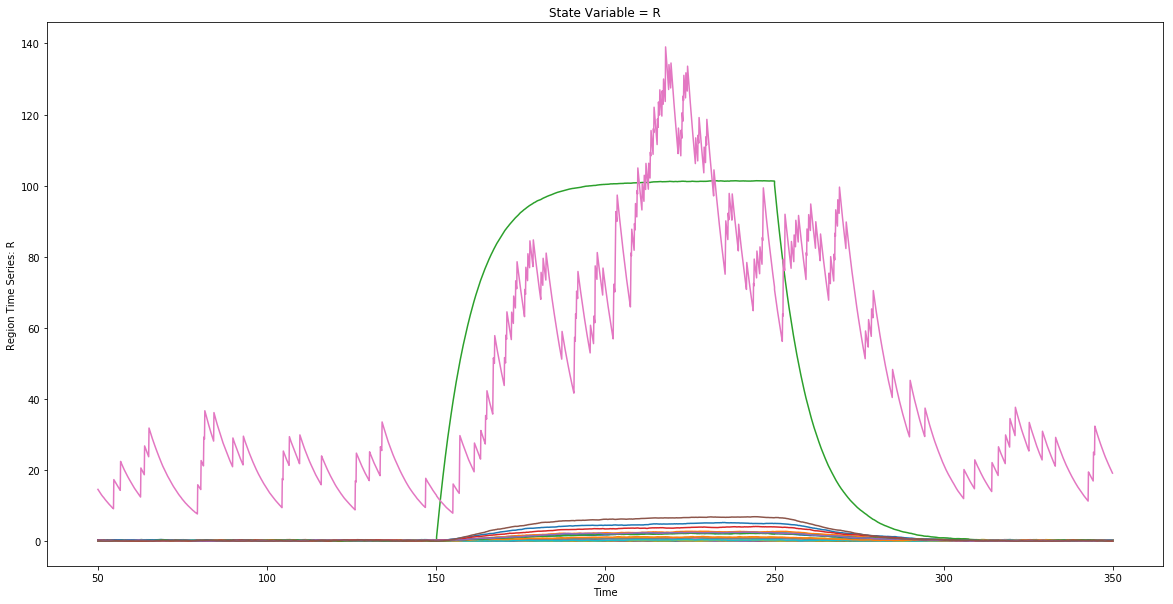

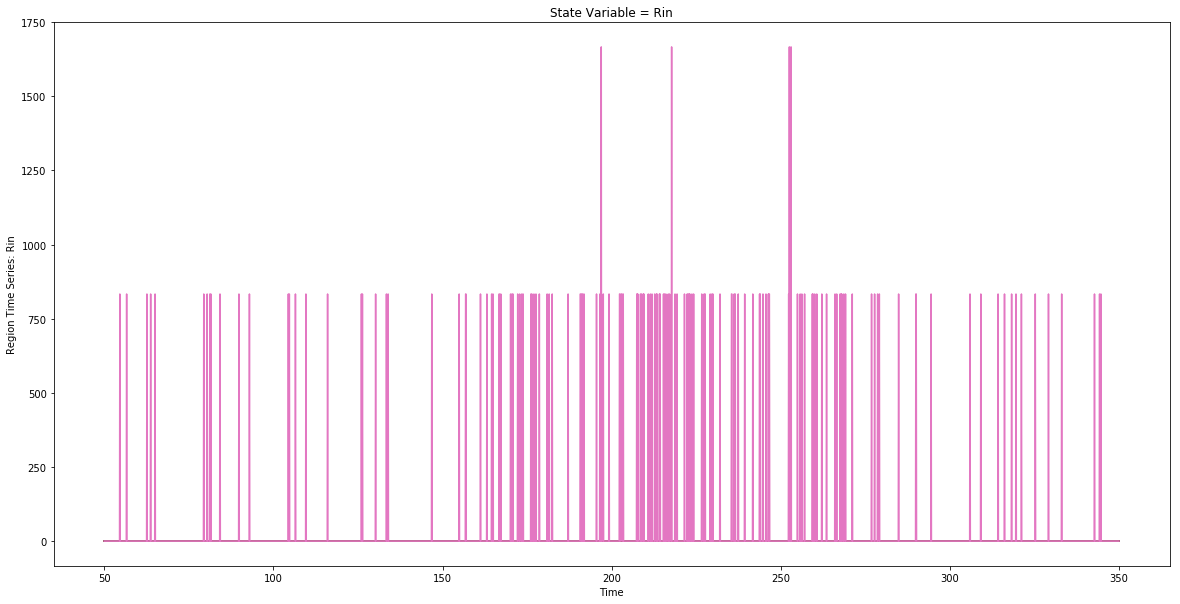

In [19]:
if source_ts is not None:
    # Plot TVB time series
    source_ts.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);

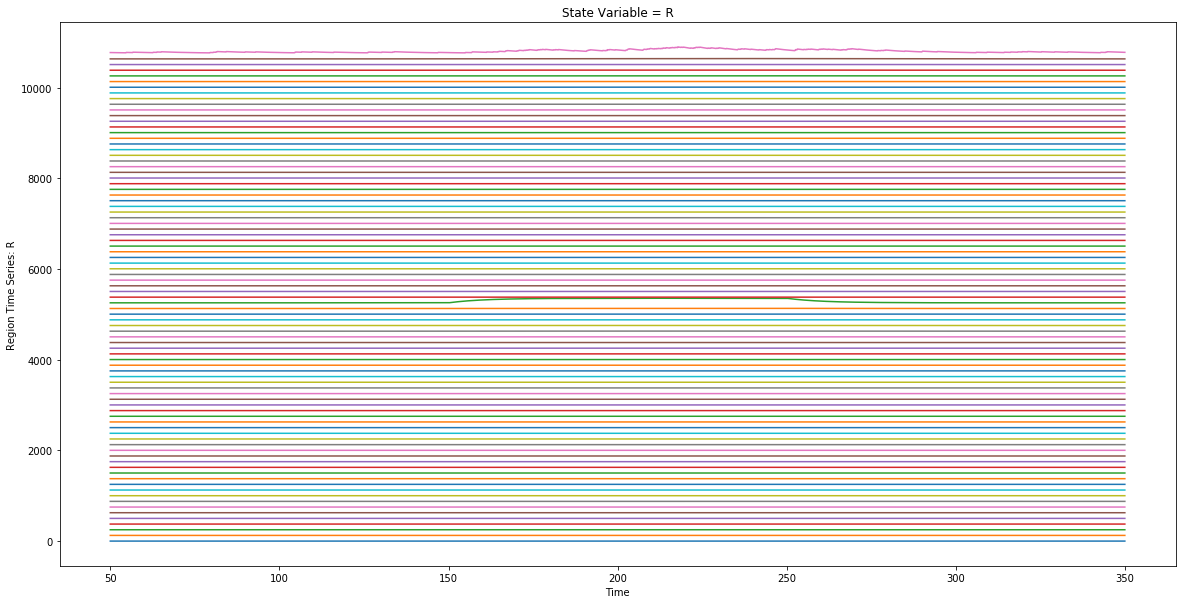

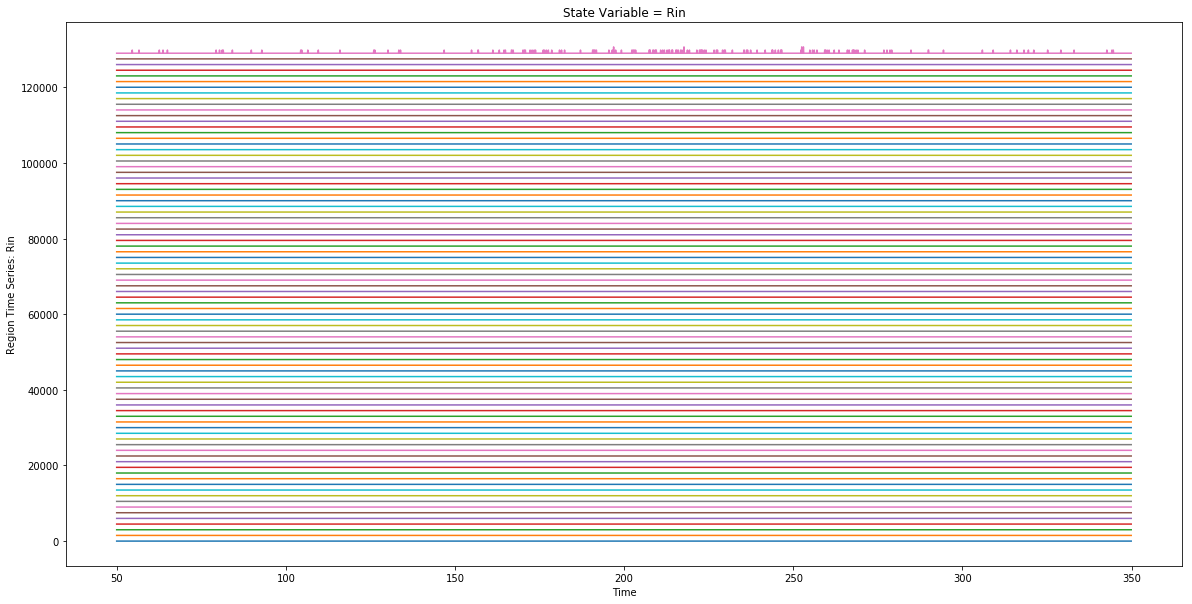

In [20]:
if source_ts is not None:
    # TVB time series raster plot:
    if source_ts.number_of_labels > 9:
        source_ts.plot_raster(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);

2020-09-10 14:58:08,914 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-10 14:58:08,957 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-10 14:58:09,206 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-10 14:58:09,240 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


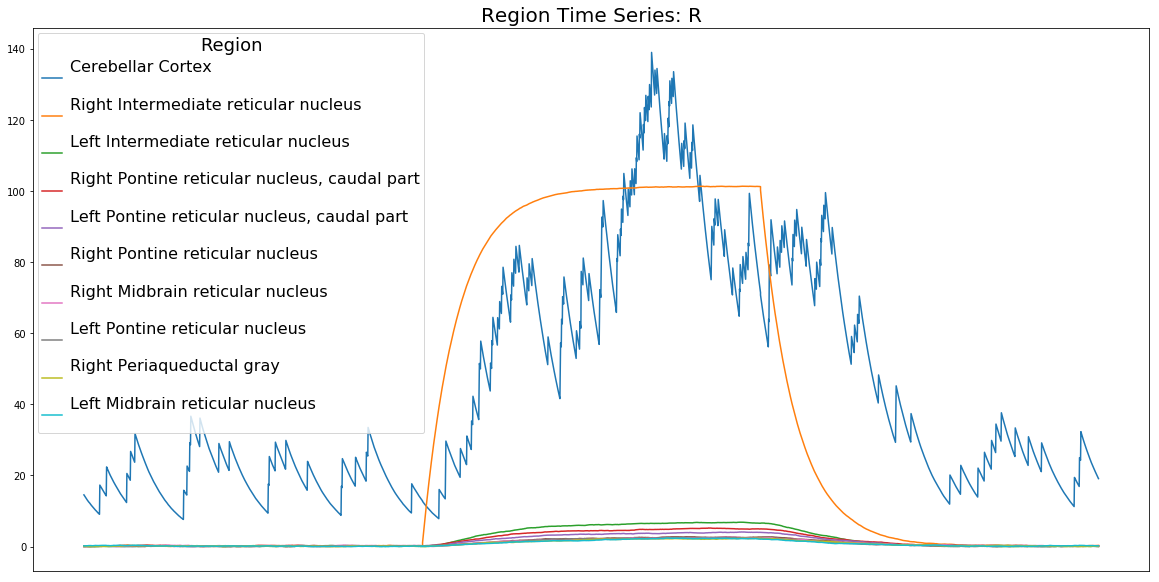

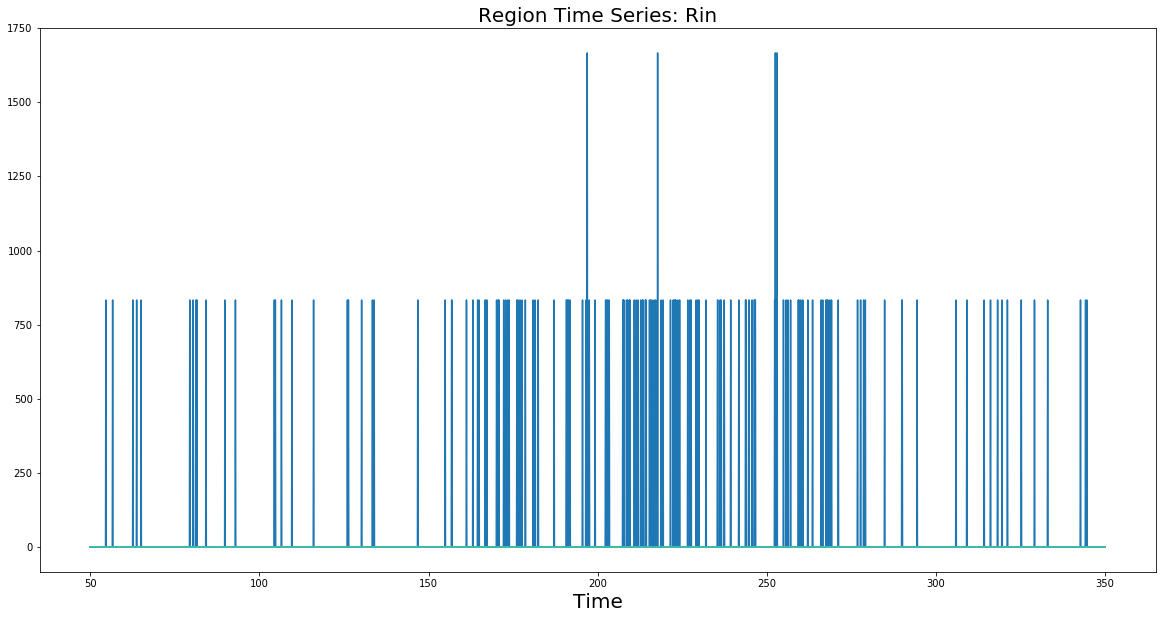

In [90]:
# A more informative figure with the 10 regions with highest mean firing rate and legend:
MeanRate = source_ts.data[:, 0].mean(axis=0).flatten()
inds = np.argsort(MeanRate)[::-1][:10]
source_ts[:,"R",inds, :].plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=True);
from matplotlib import pyplot
fontsize = 20
for ax in pyplot.gcf().axes:
#     ax.get_yticks().set_fontsize(fontsize)
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_title(ax.get_ylabel(), fontsize=fontsize)
    ax.set_ylabel("")
    for text in ax.get_legend().get_texts():
        text.set_fontsize(16)
    ax.get_legend().get_title().set_fontsize(18)
    
source_ts[:,"Rin",inds, :].plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);
for ax in pyplot.gcf().axes:
#     ax.get_yticks().set_fontsize(fontsize)
#     ax.get_xticks().set_fontsize(fontsize)
    ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize)
    ax.set_title(ax.get_ylabel(), fontsize=fontsize)
    ax.set_ylabel("")
    

### Interactive time series plot

In [21]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

In [22]:
# The stimunlated region:
# source_ts[:, :, stim_node_id].plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
#                                              figname="Stimulated region TVB Time Series");

In [91]:
# # Focus on the nodes modelled in NEST:
# try:
#     tvb_nest_model = simulator.tvb_spikeNet_interface
# except:
#     pass
# source_ts_nest = None
# if tvb_nest_model is not None:
#     n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
#     source_ts_nest = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
#     source_ts_nest.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
#                                    figname="Spiking nodes TVB Time Series");


In [24]:
# # Focus on the nodes modelled in NEST: raster plot
# if source_ts_nest is not None:
#     source_ts_nest.plot_raster(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
#                                figname="Spiking nodes TVB Time Series Raster");

### 5b. Results of TVB-NEST interface

### Plot population mean membrane potential time series

2020-09-10 13:58:01,797 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-10 13:58:01,857 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-10 13:58:02,093 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-10 13:58:02,302 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-10 13:58:02,531 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-10 13:58:02,722 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-10 13:58:02,946 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries lab

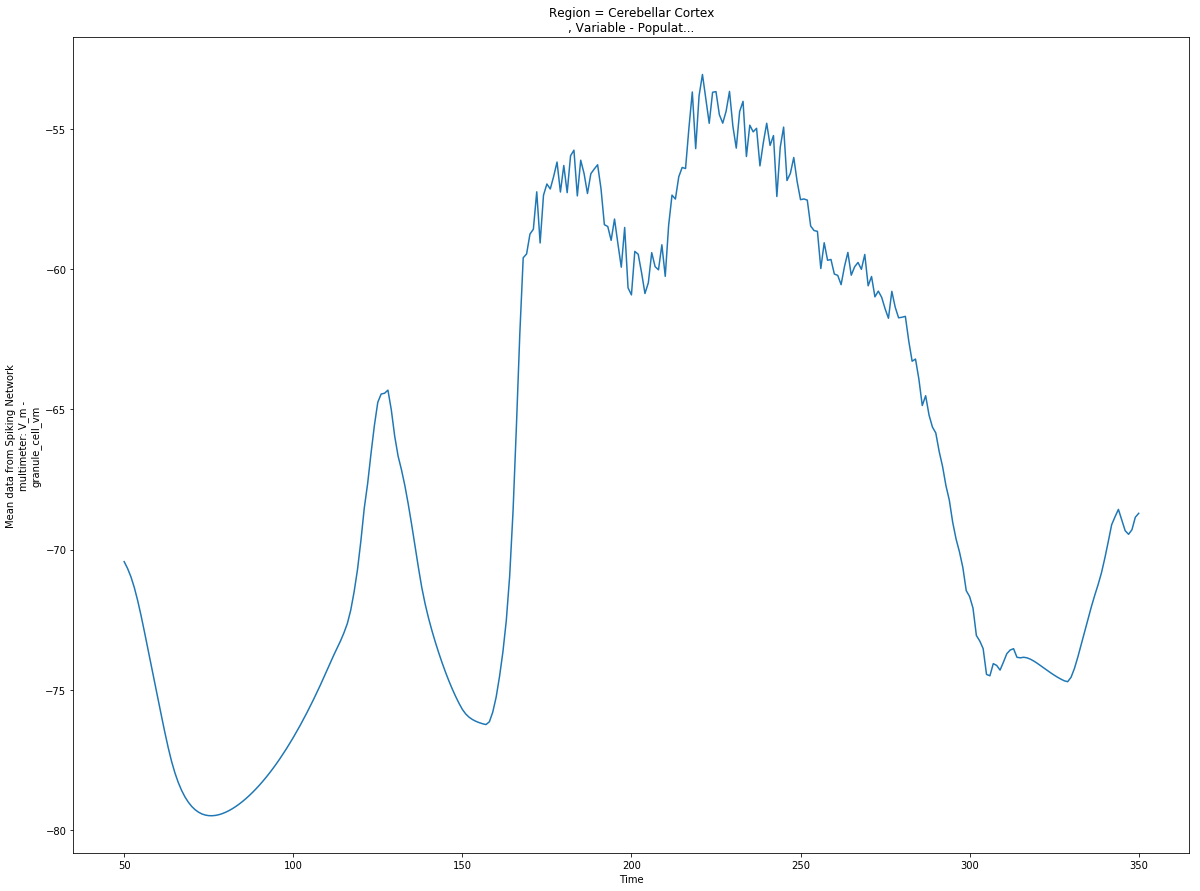

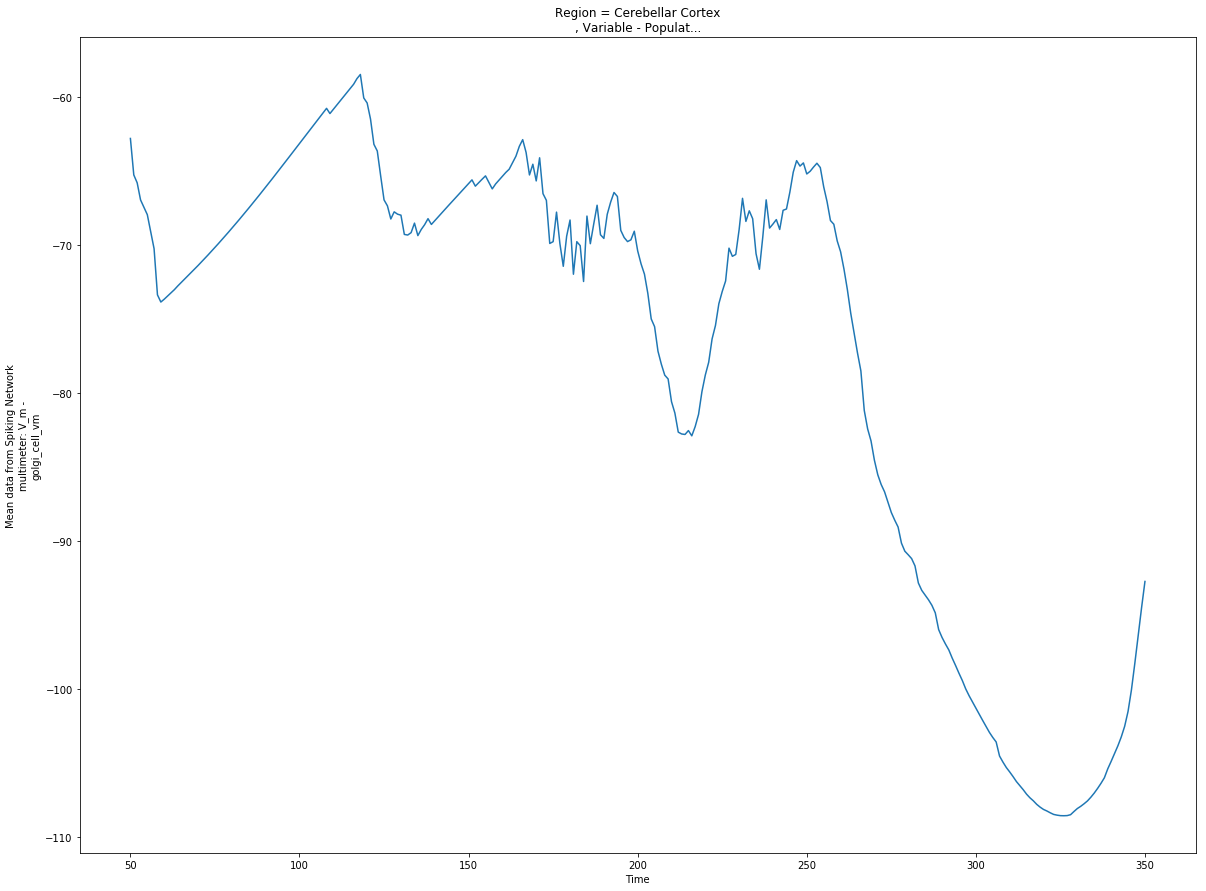

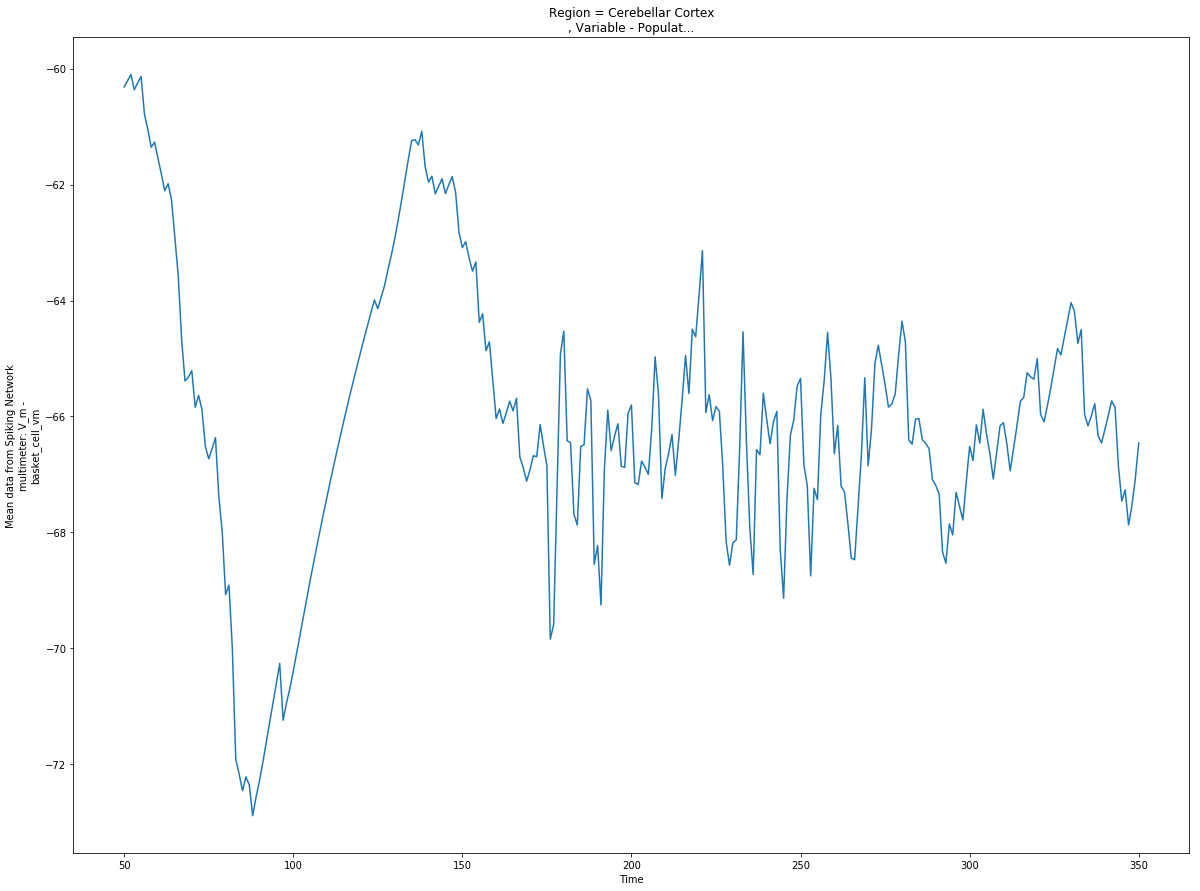

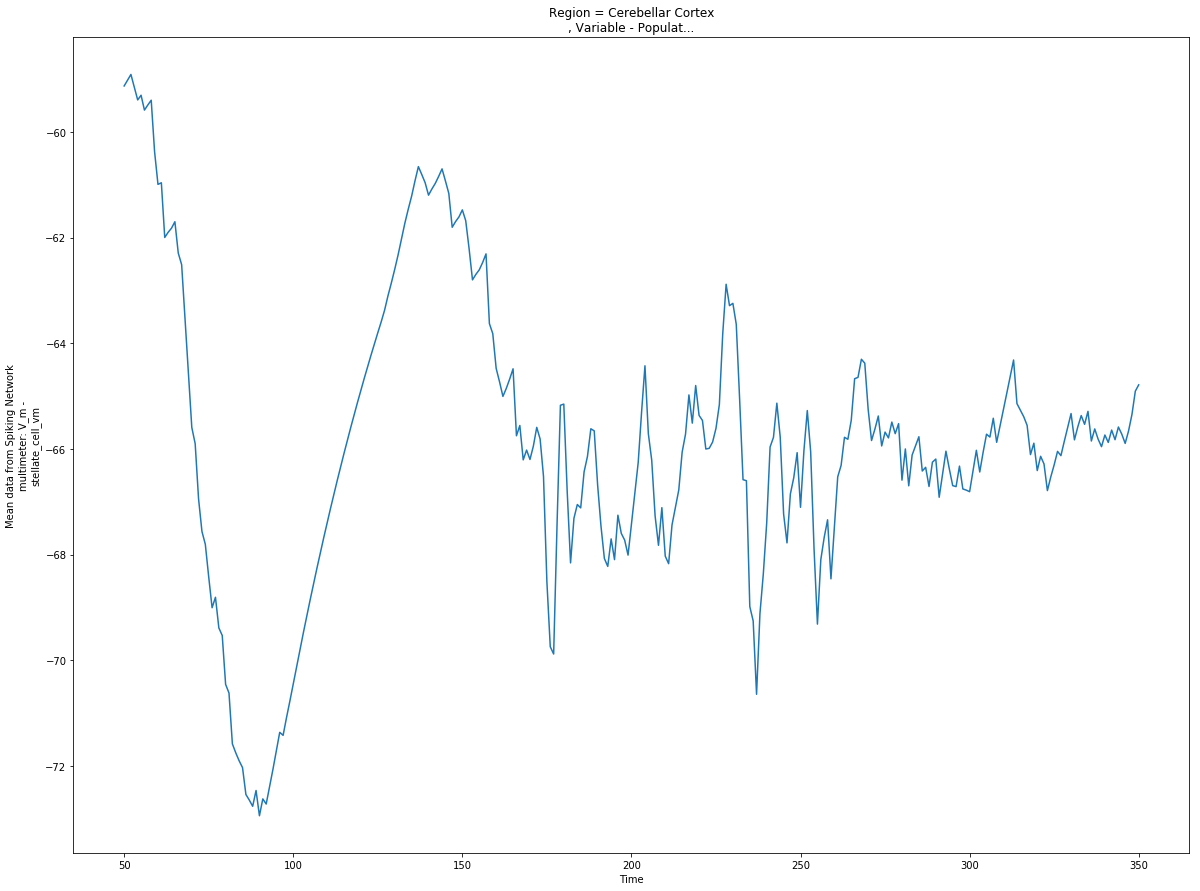

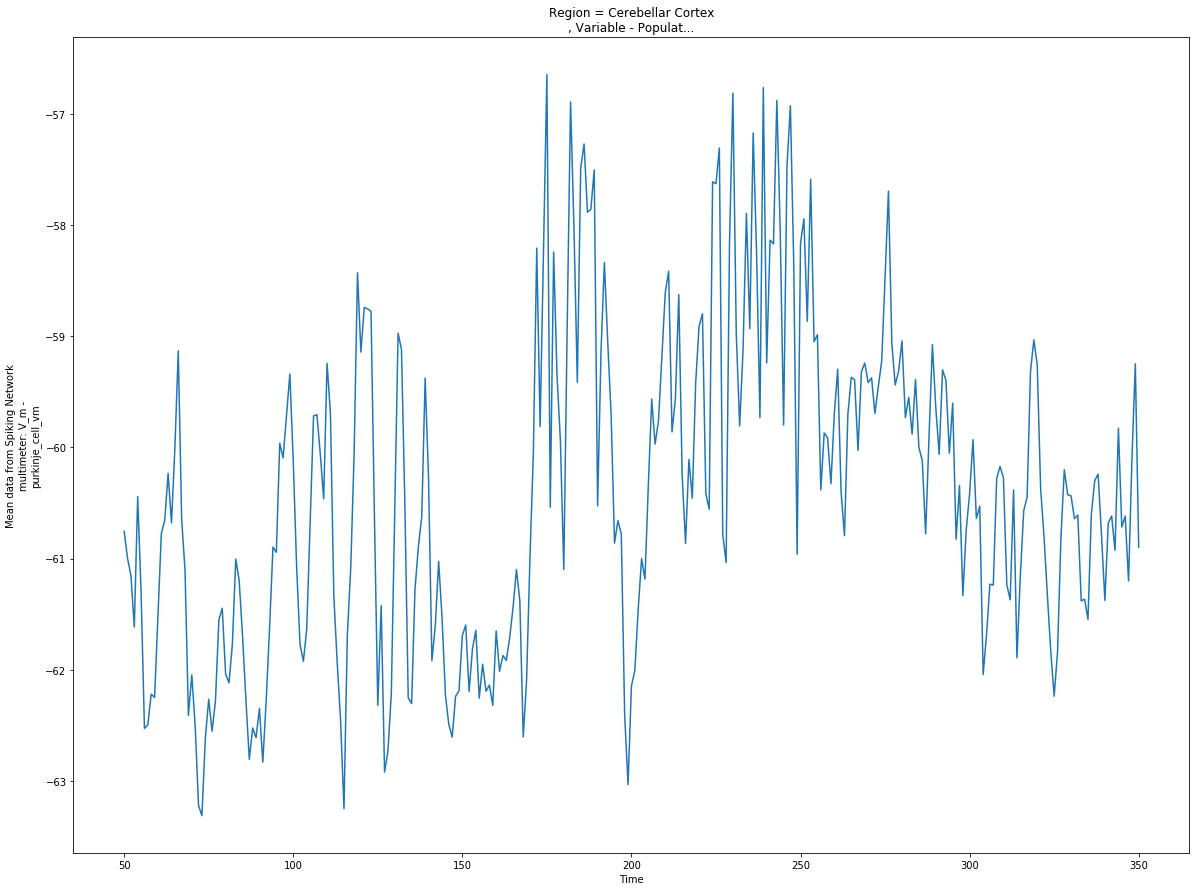

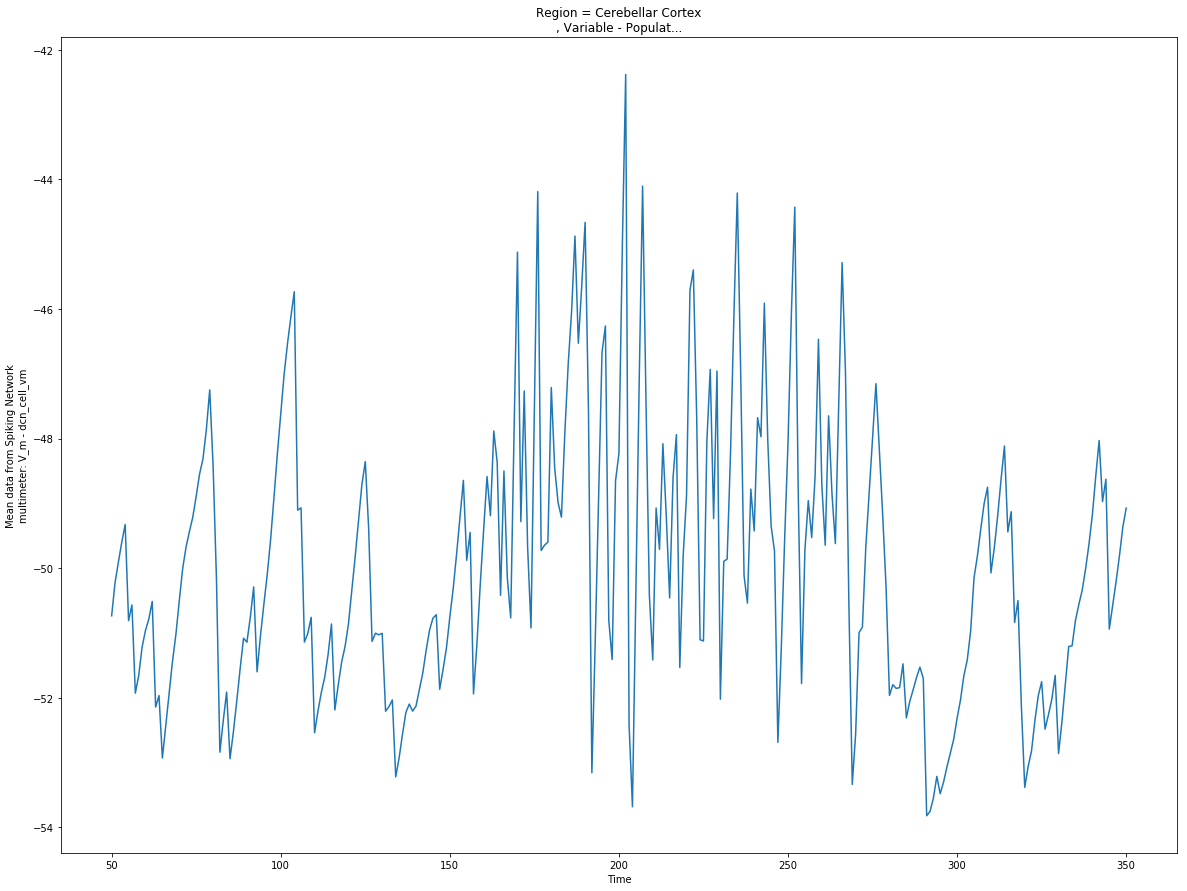

In [25]:
%matplotlib inline 
if tvb_nest_model is not None:
    tic = time.time()
    # Plot NEST multimeter variables
    # Get continuous state variables from NEST via interfaces to NEST multimeter devices
    # Get them directly as mean field quantities..
    multimeter_mean_data = \
        simulator.tvb_spikeNet_interface.get_mean_data_from_multimeter_to_TimeSeries(connectivity=simulator.connectivity)
    if transient:
        multimeter_mean_data = multimeter_mean_data[transient:]
    if multimeter_mean_data is not None and multimeter_mean_data.size > 0:
         plotter.plot_multimeter_timeseries(multimeter_mean_data, plot_per_variable=True,
                                            time_series_class=TimeSeriesXarray, time_series_args={},
                                            var_pop_join_str=" - ", default_population_label="population",
                                            figname="NEST region time series");
    if n_spiking_nodes > 3:
        plotter.plot_multimeter_raster(multimeter_mean_data, plot_per_variable=True,
                                       time_series_class=TimeSeriesXarray, time_series_args={},
                                       var_pop_join_str=" - ", default_population_label="population",
                                       figname="NEST region time series raster");
    print("\nRecovered and plotted TVB-NEST interface results in %f secs!" % (time.time() - tic))
    

### Plot spikes' raster and mean spike rate for NEST regions

In [26]:
# Plot spikes and mean field spike rates time series
# TOO SLOW FOR THE MOMENT!
# if tvb_nest_model is not None:
#     tic = time.time()
#     mf_rates_ts, spike_detectors = \
#             simulator.tvb_spikeNet_interface.get_mean_spikes_rates_to_TimeSeries(
#                 spikes_kernel_width=1.0,  # ms
#                 spikes_kernel_overlap=0.5, time=t, connectivity=simulator.connectivity)
#     if spike_detectors is not None and mf_rates_ts.size > 0:
#         plotter.plot_spike_detectors(spike_detectors, rates=mf_rates_ts, title='Population spikes and mean spike rate');
#      print("\nRecovered and plotted TVB-NEST interface mean field rate results in %f secs!" % (time.time() - tic))
    

### 5c. Results of NEST network
### Get per neuron NEST time series and plot them, as well as mean quantities

2020-09-10 13:58:05,138 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-10 13:58:05,174 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-10 13:58:05,213 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


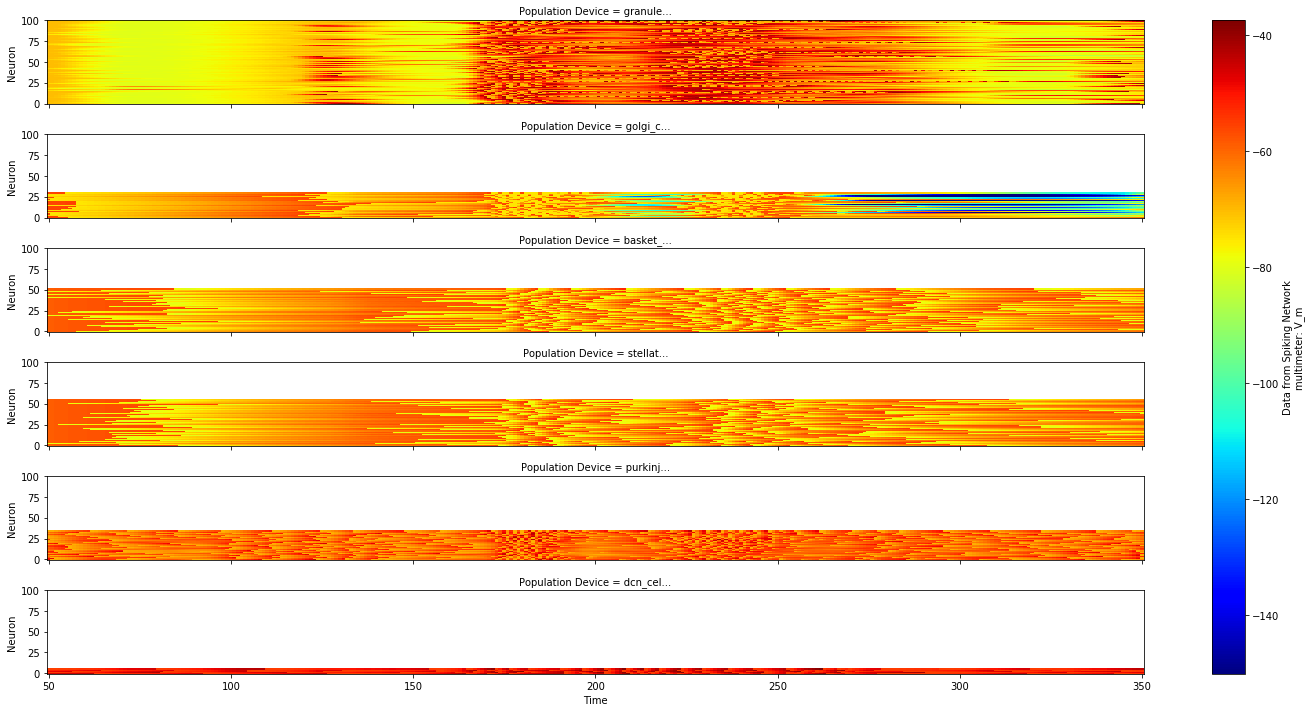

In [27]:
from xarray import DataArray
from tvb.contrib.scripts.utils.data_structures_utils import concatenate_heterogeneous_DataArrays
spiking_network = None
try:
    spiking_network = simulator.tvb_spikeNet_interface.spiking_network
except:
    spiking_network = nest_network
    n_spiking_nodes = len(nest_model_builder.nest_nodes_ids)

nest_ts = None
# TOO SLOW FOR THE MOMENT!
if spiking_network is not None:
    tic = time.time()
    # Time Series
    nest_ts = spiking_network.get_data_from_multimeter(mode="per_neuron")
    if not isinstance(nest_ts, DataArray):
        # assuming a pandas Series due to heterogeneity of populations in among brain regions:
        nest_ts = concatenate_heterogeneous_DataArrays(nest_ts, "Population",
                                                       transpose_dims=["Time", "Variable", 
                                                                       "Region", "Population", "Neuron"])
    nest_ts = TimeSeriesXarray(nest_ts, connectivity=simulator.connectivity)
    if transient:
        nest_ts = nest_ts[transient:]
    if n_spiking_nodes <= 3:
        # Regions in rows
        row = np.where(nest_ts.shape[2] > 1, nest_ts.dims[2], None).item()
        if row is None:
            # Populations in rows
            row = np.where(nest_ts.shape[3] > 1, nest_ts.dims[3], None).item()
            col = None
        else:
            # Populations in cols
            col = np.where(nest_ts.shape[3] > 1, nest_ts.dims[3], None).item()
        nest_ts.plot_map(y=nest_ts._data.dims[4], row=row, col=col,
                         per_variable=True,  cmap="jet", figsize=FIGSIZE, plotter_config=plotter.config);


2020-09-10 13:58:06,553 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-10 13:58:06,660 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!

Recovered and plotted NEST results in 2.344755 secs!


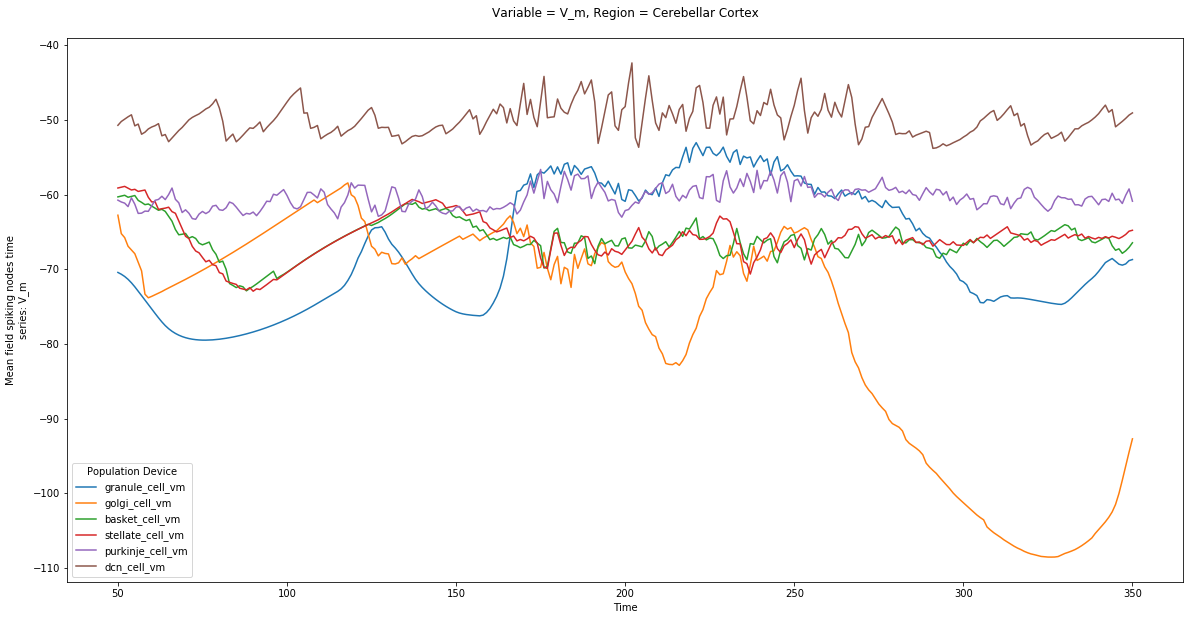

In [28]:
# Compute mean field
if nest_ts is not None:
    ts = TimeSeriesXarray(nest_ts._data.mean(axis=-1), connectivity=nest_ts.connectivity,
                          title="Mean field spiking nodes time series")
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(ts._data, connectivity=ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, ts.title)+".h5", recursive=False)
    # Plot mean field
    ts.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE)
    if n_spiking_nodes > 3:
        ts.plot_raster(plotter_config=plotter.config, per_variable=True, linestyle="--", alpha=0.5, linewidth=0.5);
    print("\nRecovered and plotted NEST results in %f secs!" % (time.time() - tic))
    

In [29]:
nest_spikes = None
if spiking_network is not None:
    from xarray import DataArray, concat

    tic = time.time()
    
    # Spikes
    nest_spikes = spiking_network.get_spikes(mode="events", return_type="Series", exclude_times=exclude_times)
    if writer:
        writer.write_object(nest_spikes.to_dict(), path=os.path.join(config.out.FOLDER_RES,  "NEST_Spikes") + ".h5")

    # Compute mean spike rates
    spike_rates = []
    if "t" in globals() and nest_ts is not None:
        t = nest_ts.time
        duration = (t[-1] - t[0])
    else:
        duration = simulation_length - transient
    duration  /= 1000   # in sec
    for i_pop, (pop_label, pop_spikes) in enumerate(nest_spikes.iteritems()):
        spike_rates.append([])
        reg_labels = []
        for reg_label, reg_spikes in pop_spikes.iteritems():
            reg_labels.append(reg_label)
            # rates (spikes/sec) =
            #   total_number_of_spikes (int) / total_time_duration (sec) / total_number_of_neurons_in_pop (int)
            spike_rates[-1].append(len(reg_spikes["times"]) / duration / populations_sizes[i_pop])
        spike_rates[-1] = np.array(spike_rates[-1])
        while spike_rates[-1].ndim < 2:
            spike_rates[-1] = spike_rates[-1][np.newaxis]
        spike_rates[-1] = DataArray(np.array(spike_rates[-1]), 
                                    dims=["Population", "Region"], name="NEST_spike_rates",
                                    coords={"Population": [pop_label], "Region": reg_labels})
    spike_rates = concat(spike_rates, spike_rates[-1].dims[0], fill_value=np.nan)
    print(spike_rates)
    if writer:
        writer.write_object(spike_rates.to_dict(), path=os.path.join(config.out.FOLDER_RES, spike_rates.name) + ".h5")

2020-09-10 13:58:07,579 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/docs/documented_example_notebook/outputs_Cereb/res/NEST_Spikes.h5
2020-09-10 13:58:07,579 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/docs/documented_example_notebook/outputs_Cereb/res/NEST_Spikes.h5
2020-09-10 13:58:07,595 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/mossy_fibers/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> senders:
[49 33 39 36 27 37  1 32  3  5 39 19  8 24 29 34 44 15 21 11 28 39 49 49
 26 31 31 27 17  5 12 49 26 26 44  6 15  3 49 40 12 30  5  7  1 13  7  1
 10  2  2 14 31 26 13 39 30 24 39 30 50 10 15 15 37 39  5 44  2  9 43 10
 44 12 26  9 33 27 15 18 48  8 39 36 43 26  8 19 10 41 19 12 50 35 39  9
 25 41 34  4 18 25  9  2 28 18 43  7 18 38 15 40 42 34 27  3 25 25 46 49
  7 32  4  2 17 31 42 37 45 35 47 30  7 21 20 3

2020-09-10 13:58:07,615 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/mossy_fibers/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 58.275 108.875 110.875 110.975 113.45  132.15  144.65  151.825 152.4
 152.525 152.8   154.425 155.55  157.025 157.15  157.675 157.7   158.075
 158.525 158.725 158.85  158.875 158.875 159.025 159.15  159.775 159.825
 160.475 160.7   160.925 161.2   161.425 161.725 162.2   162.25  162.35
 162.9   162.975 163.    163.35  163.375 163.675 163.725 163.975 164.075
 164.475 164.625 164.775 165.175 165.6   165.725 165.75  166.5   166.775
 167.3   167.5   167.6   167.625 167.625 167.7   167.85  168.05  168.05
 168.225 168.275 168.325 168.475 168.675 168.8   168.85  169.025 169.3
 169.35  169.375 169.6   169.675 169.875 170.1   170.375 171.05  171.05
 171.3   171.575 172.075 172.15  172.225 172.375 172.725 172.825 173.225
 173.4   173.5   173.775 173.9   174.05  174.125 174.125 174.275 174.3
 174.375 174.375

2020-09-10 13:58:07,672 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/golgi_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> senders:
[13277 13260 13273 13259 13280 13257 13261 13265 13284 13256 13268 13266
 13255 13274 13271 13275 13269 13272 13263 13281 13276 13258 13264 13273
 13283 13262 13259 13279 13278 13267 13280 13270 13261 13260 13257 13282
 13274 13284 13277 13263 13275 13266 13256 13265 13268 13269 13255 13271
 13272 13259 13257 13274 13263 13260 13264 13279 13275 13276 13281 13283
 13262 13284 13280 13261 13258 13266 13271 13273 13269 13267 13282 13278
 13270 13268 13255 13275 13281 13260 13264 13276 13283 13277 13257 13274
 13259 13284 13262 13263 13280 13271 13261 13265 13273 13267 13272 13282
 13275 13281 13269 13260 13266 13264 13270 13276 13278 13283 13257 13262
 13284 13259 13280 13274 13271 13263 13255 13268 13261 13258 13275 13281
 13282 13267 13260 13273 13264 13277 13276 13279 13257 13283 13270 13262


2020-09-10 13:58:07,701 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/basket_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> senders:
[13308 13300 13297 13310 13286 13302 13293 13304 13328 13292 13335 13296
 13324 13315 13331 13287 13316 13301 13321 13291 13334 13294 13285 13288
 13332 13327 13299 13309 13318 13319 13323 13290 13311 13325 13329 13306
 13320 13307 13312 13289 13317 13336 13295 13314 13322 13303 13298 13313
 13333 13296 13300 13297 13331 13302 13310 13304 13305 13326 13308 13286
 13293 13321 13328 13290 13287 13285 13323 13306 13330 13315 13335 13294
 13332 13316 13301 13320 13319 13288 13314 13309 13289 13334 13324 13307
 13311 13295 13317 13333 13312 13327 13291 13292 13303 13299 13298 13318
 13336 13313 13325 13329 13322 13296 13321 13300 13310 13326 13331 13304
 13308 13330 13315 13302 13316 13285 13293 13294 13297 13301 13306 13289
 13323 13332 13334 13295 13318 13288 13320 13311 13333 13324 13327 13314

2020-09-10 13:58:07,721 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/basket_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 52.8    55.35   56.     56.1    57.95   59.4    60.05   61.425  63.85
  64.25   64.45   65.65   65.725  66.3    66.425  66.475  67.35   67.575
  70.475  70.575  72.025  73.2    73.575  74.35   77.125  77.825  78.
  78.15   78.975  79.275  79.425  79.975  81.25   81.5    81.55   82.125
  82.125  82.4    82.55   82.575  83.225  84.7    86.975  87.575  87.75
  96.05   96.175  96.7   124.375 135.2   136.925 138.275 138.65  139.65
 141.25  144.225 147.025 148.525 148.9   149.075 152.    152.675 154.025
 154.625 154.925 156.575 156.75  158.075 158.925 159.8   159.95  161.775
 164.05  166.025 166.4   166.75  167.55  168.475 171.5   173.175 173.35
 173.525 174.1   174.35  174.85  174.925 175.05  175.425 175.475 175.525
 175.625 175.65  175.725 175.775 175.8   175.825 175.925 176.275 176.5
 176.575 1

2020-09-10 13:58:07,735 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/stellate_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> senders:
[13389 13411 13439 13438 13388 13347 13399 13382 13375 13405 13379 13364
 13434 13448 13435 13415 13350 13449 13418 13377 13395 13353 13369 13358
 13391 13365 13430 13357 13345 13359 13412 13397 13384 13441 13341 13349
 13427 13356 13394 13352 13387 13409 13355 13417 13407 13421 13406 13443
 13362 13431 13360 13374 13376 13419 13447 13404 13344 13413 13414 13433
 13340 13390 13363 13393 13420 13346 13370 13386 13422 13445 13348 13367
 13351 13385 13383 13400 13410 13354 13373 13429 13426 13432 13403 13396
 13425 13436 13424 13423 13378 13408 13440 13339 13366 13361 13442 13371
 13368 13381 13444 13401 13337 13402 13380 13437 13338 13392 13416 13388
 13379 13446 13443 13343 13448 13342 13369 13352 13444 13415 13389 13439
 13414 13412 13345 13353 13433 13365 13413 13434 13410 13398 13387 134

2020-09-10 13:58:07,765 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/stellate_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 52.8    53.475  55.725  57.35   57.375  58.4    58.425  58.55   58.875
  59.025  59.225  59.45   59.45   59.75   61.025  61.45   61.7    61.7
  61.725  61.825  65.65   65.8    66.025  67.15   67.65   67.725  67.725
  67.775  68.05   68.25   68.325  68.4    68.65   69.325  69.55   69.825
  70.325  70.65   71.275  71.4    71.475  71.65   71.85   72.55   72.625
  73.5    73.6    74.225  74.65   74.95   75.     75.     75.     75.35
  75.35   76.825  76.9    77.2    77.45   77.975  78.2    78.475  78.625
  79.075  79.175  79.2    79.2    79.2    79.25   79.375  79.4    79.675
  80.5    81.025  81.125  81.55   81.775  81.825  81.975  82.55   83.1
  83.175  83.725  83.95   84.175  84.55   84.925  85.275  85.625  85.725
  85.775  85.825  85.95   86.2    87.225  87.925  88.     89.075  89.225
  89

2020-09-10 13:58:07,775 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/purkinje_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> senders:
[13474 13450 13455 ... 13459 13452 13467] !

2020-09-10 13:58:07,782 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/purkinje_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 50.2    50.325  50.75  ... 349.5   349.55  349.95 ] !

2020-09-10 13:58:07,782 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/purkinje_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 50.2    50.325  50.75  ... 349.5   349.55  349.95 ] !

2020-09-10 13:58:07,790 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/dcn_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> senders:
[13486 13488 13485 13486 13489 13490 13487 13486 1

2020-09-10 13:58:08,065 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "NEST_spike_rates.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[ 41.26666667]
 [ 41.0770751 ]
 [ 43.64391951]
 [ 47.        ]
 [ 37.62820513]
 [ 28.64306785]
 [111.04761905]
 [ 90.        ]] !

2020-09-10 13:58:08,065 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "NEST_spike_rates.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[ 41.26666667]
 [ 41.0770751 ]
 [ 43.64391951]
 [ 47.        ]
 [ 37.62820513]
 [ 28.64306785]
 [111.04761905]
 [ 90.        ]] !

2020-09-10 13:58:08,071 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2020-09-10 13:58:08,071 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2020-09-10 13:58:08,074 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file


Recovered and plotted NEST spikes and computed spike rates in 1.486103 secs!


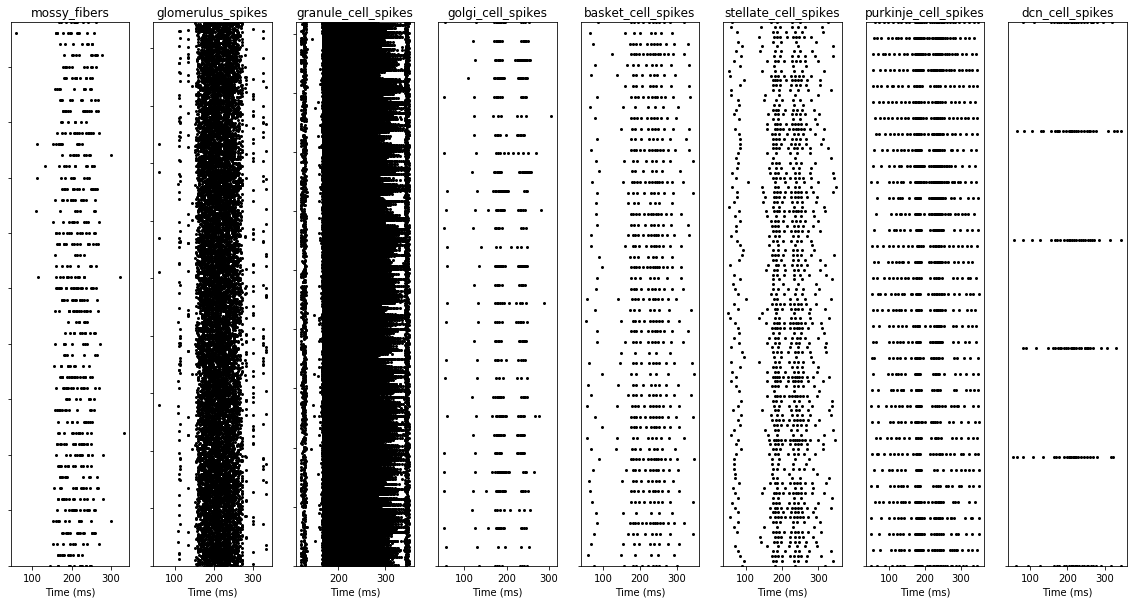

In [30]:
# Plot spikes
if nest_spikes is not None:
    plotter.plot_spike_events(nest_spikes, figsize=FIGSIZE);
    print("\nRecovered and plotted NEST spikes and computed spike rates in %f secs!" % (time.time() - tic))

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>

In [31]:
list(zip(dict(spike_rates.coords)["Population"].values.tolist(), spike_rates.values.tolist()))

[('mossy_fibers', [41.26666666666667]),
 ('glomerulus_spikes', [41.07707509881423]),
 ('granule_cell_spikes', [43.64391951006125]),
 ('golgi_cell_spikes', [47.0]),
 ('basket_cell_spikes', [37.62820512820513]),
 ('stellate_cell_spikes', [28.64306784660767]),
 ('purkinje_cell_spikes', [111.04761904761905]),
 ('dcn_cell_spikes', [90.0])]